In [1]:

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import astropy

from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy.timeseries import TimeSeries
from astropy.time import Time
from astropy.timeseries import TimeSeries, aggregate_downsample
from astropy.coordinates import match_coordinates_sky as coords
from astropy.coordinates import SpectralCoord
import astropy.units as u
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

from mid_IR_variables import fileIO_processing as fp
from mid_IR_variables import lightcurve_processing as lp
from mid_IR_variables import ZTF_lightcurve_processing as zlp
from mid_IR_variables import reverberation_mapper 
from mid_IR_variables import MCMC_sampler


from sklearn.gaussian_process import GaussianProcessRegressor, kernels

from scipy import optimize
import scipy.stats as stats

import os

import corner

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})
matplotlib.rc('font',**{'family':'serif','serif':['Times']})
matplotlib.rc('text', usetex=True)

SAVE_FILEPATH = 'C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/Figures/'
IMPORT_FILEPATH ='C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/'

mnsa_hdu, manga_wise_hdu, pipe3d_hdu = fp.import_manga(6, 1, 1)
mnsa, mwv, pipe3d = mnsa_hdu.data, manga_wise_hdu.data, pipe3d_hdu.data

In [2]:
CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=18),
    labels = [r'$\Delta t$', 'AMP', 'const'],
    title_kwargs=dict(fontsize=18),
    quantiles=[0.16, 0.5, 0.84],
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=True,
    #fill_contours=1,
    show_titles=True,
    max_n_ticks=3,
    title_fmt=".2f",
    bins=30
)

pifus = np.array([ '10223-3701', '9000-1901', '7977-9101', '9186-9101','8091-6101', '9487-9102', '8593-12705', '8615-3701','7981-9102', '8341-12704', 
                  '8466-3704', '8561-3704', '8091-9101', '9870-9101', '9514-1901', '9487-3702', '8710-6102', '11833-3702', '11944-12704', 
                  '8553-1901', '12071-12703', '9887-1901', '10516-12701', '7815-6104', '8132-6101', '8612-1901', '8619-12702', '9497-12705', '9502-12703',
                    '12483-9102', '12511-3702', '8326-6102', '8714-3704', '8999-3702'])

In [9]:
def generate_rows(pifus):
    rows = []
    w1_lags = np.array([])
    w2_lags = np.array([])
    for i, pifu in enumerate(pifus[:]):
        row = np.array([pifu])

        print("object", str(i), "of", str(pifus.shape[0]))
        print(pifu)
        os.makedirs(SAVE_FILEPATH+"/Reverb_Lags/plateifu/"+pifu, exist_ok=True)


        GP = TimeSeries.read('C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/Data/GP/'+pifu+'.txt', format='ascii.ipac', time_column='time', time_format='decimalyear')
        RM = reverberation_mapper.reverberation_mapper(pifu, optical_data=GP)
        minimizer_args = {"model":'brute', "x0":[0.2, 1, 1], "ranges": ((0, 1.5, 0.002),), "wise band": 1, "verbose": 0}
        model1 = RM.minimize_chisq(minimizer_args)
        m1 = model1[0]#*365.2422 ##conversion to days
        w1_lags = np.append(w1_lags, m1)

        minimizer_args = {"model":'brute', "x0":[0.2, 1, 1], "ranges": ((0, 1.5, 0.002),), "wise band": 2, "verbose": 0}
        model2 = RM.minimize_chisq(minimizer_args)
        m2 = model2[0]#*365.2422 ##conversion to days
        w2_lags = np.append(w2_lags, m2)


        a = np.where(RM.chisq_w1 == np.nanmin(RM.chisq_w1))[0][0]
        b = np.where(RM.chisq_w2 == np.nanmin(RM.chisq_w2))[0][0]

        m1 = np.append(m1, RM.amp1[a])
        m1 = np.append(m1, RM.const1[a])
        row = np.append(row, m1)

        m2 = np.append(m2, RM.amp2[b])
        m2 = np.append(m2, RM.const2[b])
        row = np.append(row, m2)

        mcmc = MCMC_sampler.MCMC(RM.optical_GP, RM.w1)

        initial = m1
        p0 = [np.array(initial[1:]) +  1e1 * np.random.randn(2) for i in range(100)]
        p0 = np.insert(p0, 0, np.random.normal(loc=0, scale=0.4, size=len(p0)), axis=1)

        mcmc_args = {"initial":initial, "p0": p0, "ranges":((-1.5, 1.5), (-100, 100), (-100, 100))}
        mcmc.run_MCMC(mcmc_args)
        samples = mcmc.sampler.flatchain

        #fig = corner.corner(samples, **CORNER_KWARGS)
        # must be done once per variable
        
        q_16, q_50, q_84 = corner.quantile(samples[:, 0], [0.16, 0.5, 0.84]) # your x is q_50
        dx_down, dx_up = q_50-q_16, q_84-q_50
        row = np.append(row, np.array([dx_down, dx_up]))#*365.2422) ##conversion to days
        mcmc.generate_corner_plot(CORNER_KWARGS)
        plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'mcmc_w1.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

        mcmc.set_IR_data(RM.w2)

        initial = m2
        p0 = [np.array(initial[1:]) + 1e1 * np.random.randn(2) for i in range(100)]
        p0 = np.insert(p0, 0, np.random.normal(loc=0, scale=0.4,size=len(p0)), axis=1)
        mcmc_args = {"initial":initial, "p0": p0, "ranges":((-1.5, 1.5), (-100, 100), (-100, 100))}
        mcmc.run_MCMC(mcmc_args)
        samples = mcmc.sampler.flatchain
        #fig = corner.corner(samples, **CORNER_KWARGS)
        
        q_16, q_50, q_84 = corner.quantile(samples[:, 0], [0.16, 0.5, 0.84]) # your x is q_50
        dx_down, dx_up = q_50-q_16, q_84-q_50
        row = np.append(row, np.array([dx_down, dx_up]))#*365.2422)
        mcmc.generate_corner_plot(CORNER_KWARGS)
        plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'mcmc_w2.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
        print(row)
        rows.append(row)
    return rows

In [ ]:
rows = generate_rows(pifus)

In [11]:
rows

[array(['10223-3701', '0.22', '5.612946823934482', '13.490747035946677',
        '0.364', '7.204759294518239', '13.634898991196257',
        '0.021413146400342614', '0.02337958067134638',
        '0.018218226881019595', '0.01882581607227085'], dtype='<U32'),
 array(['9000-1901', '0.0', '1.9013507868307096', '13.965150492470839',
        '0.092', '2.020823057755979', '13.888883889184887',
        '0.03401408348473265', '0.03243944111564391',
        '0.03608558855385564', '0.03666718494088138'], dtype='<U32'),
 array(['7977-9101', '0.048', '1.1953787278363595', '14.231139129001791',
        '0.232', '1.5587900515557804', '14.51728632378981',
        '0.06037043794394907', '0.06707765006136124',
        '0.07610050740018212', '0.0689813732987361'], dtype='<U32'),
 array(['9186-9101', '0.216', '0.7857959464340765', '13.411106361140826',
        '0.264', '0.7037030357706712', '13.380107005455354',
        '0.03998847423024007', '0.04250471920526028',
        '0.05578409752164146', '0.07238

In [39]:
tab = Table(names=['plateifu', 'lag_w1', 'amp_w1', 'const_w1', 'lag_w2', 'amp_w2', 'const_w2', 'lag_w1_yerr_min', 'lag_w1_yerr_max', 'lag_w2_yerr_min', 'lag_w2_yerr_max'], 
            dtype=[str, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64])
for row in rows:
    tab.add_row(row)
tab['lag_w1'] *= 365.2422
tab['lag_w2'] *= 365.2422
tab['lag_w1_yerr_min'] *= 365.2422
tab['lag_w1_yerr_max'] *= 365.2422
tab['lag_w2_yerr_min'] *= 365.2422
tab['lag_w2_yerr_max'] *= 365.2422
tab.write('reverb_lags', format='ascii.ipac', overwrite=True)

In [40]:
tab

plateifu,lag_w1,amp_w1,const_w1,lag_w2,amp_w2,const_w2,lag_w1_yerr_min,lag_w1_yerr_max,lag_w2_yerr_min,lag_w2_yerr_max
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10223-3701,80.353284,5.612946823934482,13.490747035946677,132.9481608,7.204759294518239,13.634898991196257,7.820984700183217,8.539209479480029,6.6540652661227355,6.875982479031565
9000-1901,0.0,1.9013507868307096,13.965150492470839,33.6022824,2.020823057755979,13.888883889184887,12.42337868294742,11.848252839848238,13.179979751705051,13.392403295614386
7977-9101,17.5316256,1.1953787278363595,14.231139129001791,84.73619040000001,1.5587900515557804,14.51728632378981,22.049831569611438,24.499588479241716,27.7951167439588,25.194908542651632
9186-9101,78.8923152,0.7857959464340765,13.411106361140826,96.42394080000001,0.7037030357706712,13.380107005455354,14.605478302496191,15.524517152911516,20.374706503818874,26.437188476454846
8091-6101,29.219376000000004,0.9668701176090825,14.02215346910758,88.3886124,1.2605725153640093,14.097740414633677,34.82380269568833,34.95731420024324,30.17515914409339,29.84247415278162
9487-9102,161.4370524,1.1504476292087815,13.771862765687944,547.1328156000001,1.5108866737890696,13.776816847764277,54.45489484571819,110.29062295590158,93.96565130479296,207.53430178478504
8593-12705,145.3663956,0.9552630891557333,14.006631088770195,183.3515844,1.284215569129718,14.227314138700857,41.473377428592464,39.77361412755918,30.173777925482305,29.50660259654191
8615-3701,111.0336288,1.1441048144860733,15.141466967389867,160.706568,1.955234974439713,15.33119440293353,84.79665259435464,80.81205537803606,49.793920215317954,48.600278659961816
7981-9102,172.39431840000003,0.6698613096780281,14.837823204584272,219.87580440000002,0.5345764735875086,14.766370015743334,50.22071153071811,50.28191916879253,439.1007706806725,94.34633778141342


In [ ]:
##9487-9102: rerun MCMC between (-1.5, 1) years
##8553-1901: rerun MCMC between (0, 1) years
##7981-9102: rerun MCMC between (0, 1.5) years
##8326-6102: rerun MCMC between (0, 1.5) years
##8714-3704: rerun MCMC between (0, 2) years -- might not be required
##8091-9101: rerun MCMC between (1, 3) years -- no detected lag
##12511-3702: rerun MCMC between (0, 3) years
##8619-12702: rerun MCMC between (0, 3.5) years


second_run_plateifus = np.array(['9487-9102', '7981-9102', '8091-9101', '8553-1901', '8619-12702', '12511-3702', '8326-6102', '8714-3704'])

second_run_ranges = np.array([(-1.5, 1), (0, 1.5), (1, 3), (0, 1), (0, 3.5), (0, 3), (0, 1.5), (0, 2)])
second_run_rows = []
w1_lags = np.array([])
w2_lags = np.array([])
for i, pifu in enumerate(second_run_plateifus):
        row = np.array([pifu])

        print("object", str(i), "of", str(pifus.shape[0]))
        print(pifu)
        #os.makedirs(SAVE_FILEPATH+"/Reverb_Lags/plateifu/"+pifu, exist_ok=True)


        GP = TimeSeries.read('C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/Data/GP/'+pifu+'.txt', format='ascii.ipac', time_column='time', time_format='decimalyear')
        RM = reverberation_mapper.reverberation_mapper(pifu, optical_data=GP)
        minimizer_args = {"model":'brute', "x0":[0.2, 1, 1], "ranges": ((second_run_ranges[i][0], second_run_ranges[i][1], 0.002),), "wise band": 1, "verbose": 0}
        model1 = RM.minimize_chisq(minimizer_args)
        m1 = model1[0]#*365.2422 ##conversion to days
        w1_lags = np.append(w1_lags, m1)

        minimizer_args = {"model":'brute', "x0":[0.2, 1, 1], "ranges": ((second_run_ranges[i][0], second_run_ranges[i][1], 0.002),), "wise band": 2, "verbose": 0}
        model2 = RM.minimize_chisq(minimizer_args)
        m2 = model2[0]#*365.2422 ##conversion to days
        w2_lags = np.append(w2_lags, m2)


        a = np.where(RM.chisq_w1 == np.nanmin(RM.chisq_w1))[0][0]
        b = np.where(RM.chisq_w2 == np.nanmin(RM.chisq_w2))[0][0]

        m1 = np.append(m1, RM.amp1[a])
        m1 = np.append(m1, RM.const1[a])
        row = np.append(row, m1)

        m2 = np.append(m2, RM.amp2[b])
        m2 = np.append(m2, RM.const2[b])
        row = np.append(row, m2)

        mcmc = MCMC_sampler.MCMC(RM.optical_GP, RM.w1)

        initial = m1
        p0 = [np.array(initial[1:]) +  1e1 * np.random.randn(2) for i in range(100)]
        p0 = np.insert(p0, 0, np.random.normal(loc=0.5, scale=0.4, size=len(p0)), axis=1)

        mcmc_args = {"initial":initial, "p0": p0, "ranges":(second_run_ranges[i], (-100, 100), (-100, 100))}
        mcmc.run_MCMC(mcmc_args)
        samples = mcmc.sampler.flatchain

        #fig = corner.corner(samples, **CORNER_KWARGS)
        # must be done once per variable
        
        q_16, q_50, q_84 = corner.quantile(samples[:, 0], [0.16, 0.5, 0.84]) # your x is q_50
        dx_down, dx_up = q_50-q_16, q_84-q_50
        row = np.append(row, np.array([dx_down, dx_up]))#*365.2422) ##conversion to days
        mcmc.generate_corner_plot(CORNER_KWARGS)
        plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'mcmc_w1_run2.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

        mcmc.set_IR_data(RM.w2)

        initial = m2
        p0 = [np.array(initial[1:]) + 1e1 * np.random.randn(2) for i in range(100)]
        p0 = np.insert(p0, 0, np.random.normal(loc=0.5, scale=0.4,size=len(p0)), axis=1)
        mcmc_args = {"initial":initial, "p0": p0, "ranges":(second_run_ranges[i], (-100, 100), (-100, 100))}
        mcmc.run_MCMC(mcmc_args)
        samples = mcmc.sampler.flatchain
        #fig = corner.corner(samples, **CORNER_KWARGS)
        
        q_16, q_50, q_84 = corner.quantile(samples[:, 0], [0.16, 0.5, 0.84]) # your x is q_50
        dx_down, dx_up = q_50-q_16, q_84-q_50
        row = np.append(row, np.array([dx_down, dx_up]))#*365.2422)
        mcmc.generate_corner_plot(CORNER_KWARGS)
        plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'mcmc_w2_run2.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
        print(row)
        second_run_rows.append(row)
# tab = Table.read('reverb_lags', format='ascii.ipac')
# for i, pifu in enumerate(second_run_plateifus):

#     j = np.where(tab['plateifu']==pifu)[0]
#     print(tab[j])
#     tab[j] = second_run_rows[i]

object 7 of 34
8091-9101
**IR Data Generated**
Running burn-in...
Running production...
Running burn-in...
Running production...


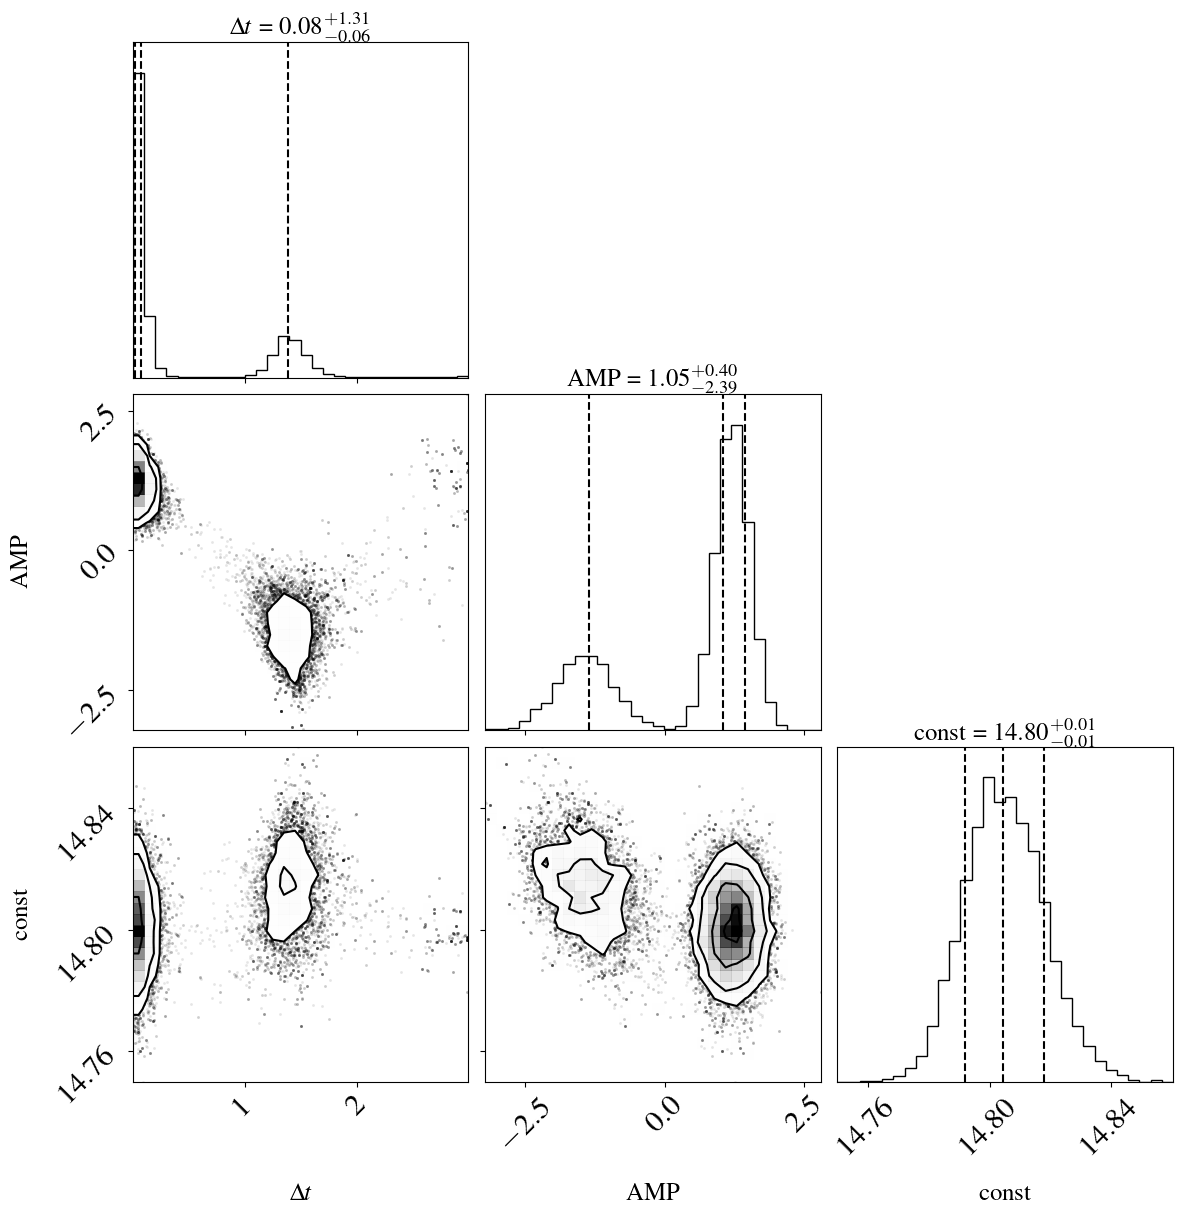

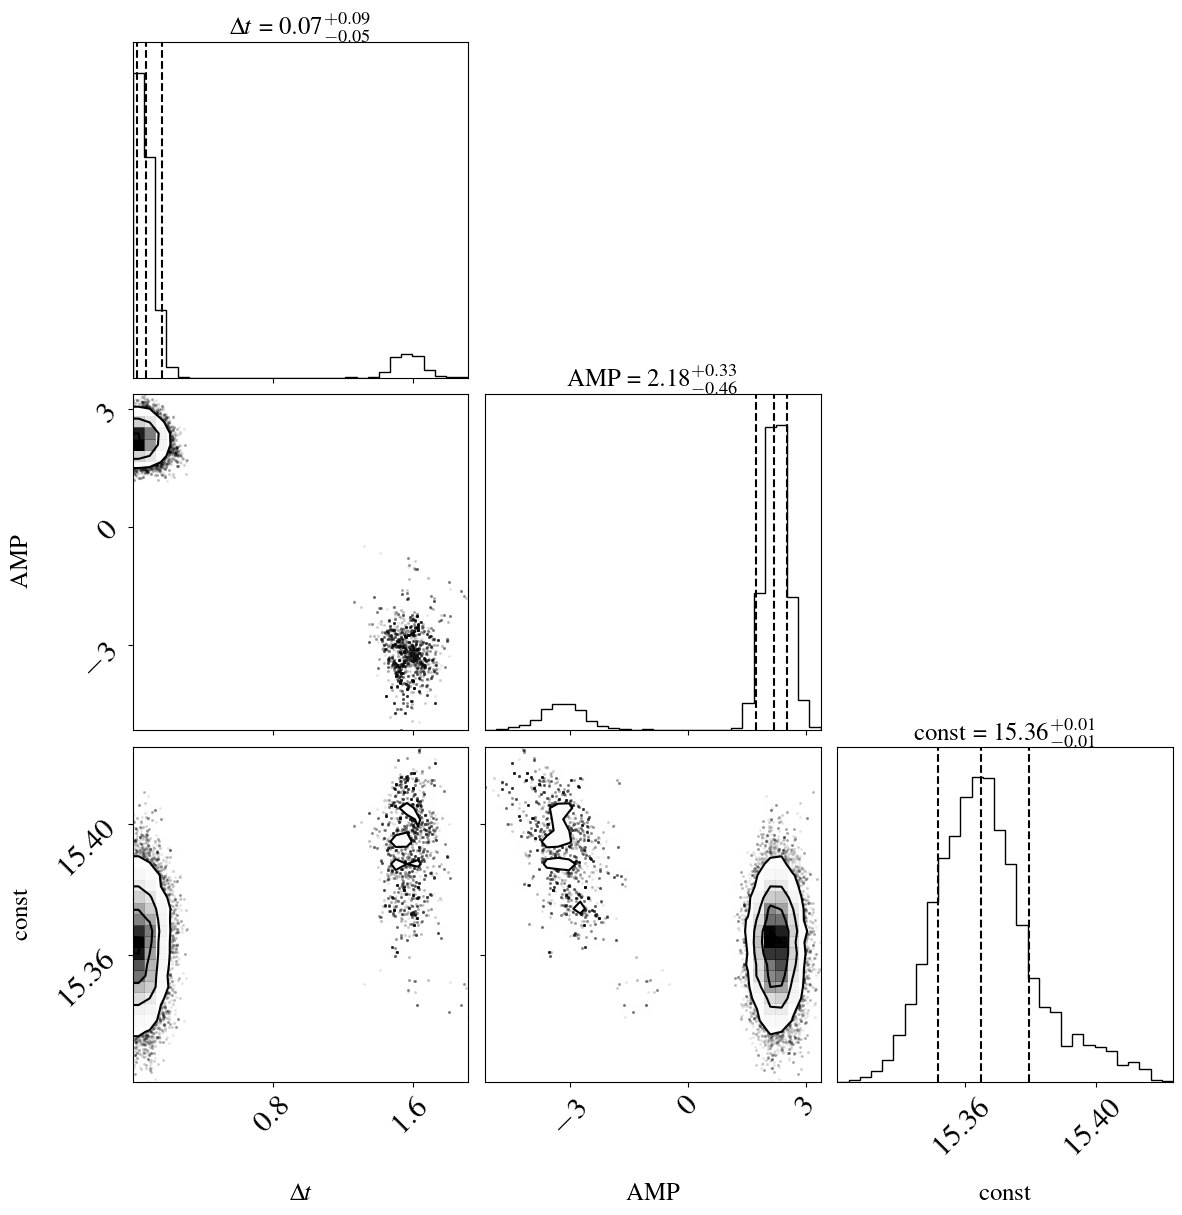

In [106]:
pifu = '8091-9101'
row = np.array([pifu])

print("object", str(i), "of", str(pifus.shape[0]))
print(pifu)
#os.makedirs(SAVE_FILEPATH+"/Reverb_Lags/plateifu/"+pifu, exist_ok=True)


GP = TimeSeries.read('C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/Data/GP/'+pifu+'.txt', format='ascii.ipac', time_column='time', time_format='decimalyear')
RM = reverberation_mapper.reverberation_mapper(pifu, optical_data=GP)
minimizer_args = {"model":'brute', "x0":[0.2, 1, 1], "ranges": ((0, 3, 0.002),), "wise band": 1, "verbose": 0}
model1 = RM.minimize_chisq(minimizer_args)
m1 = model1[0]*365.2422 ##conversion to days
# w1_lags = np.append(w1_lags, m1)

minimizer_args = {"model":'brute', "x0":[0.2, 1, 1], "ranges": ((0, 3, 0.002),), "wise band": 2, "verbose": 0}
model2 = RM.minimize_chisq(minimizer_args)
m2 = model2[0]*365.2422 ##conversion to days
# w2_lags = np.append(w2_lags, m2)


a = np.where(RM.chisq_w1 == np.nanmin(RM.chisq_w1))[0][0]
b = np.where(RM.chisq_w2 == np.nanmin(RM.chisq_w2))[0][0]

m1 = np.append(m1, RM.amp1[a])
m1 = np.append(m1, RM.const1[a])
row = np.append(row, m1)

m2 = np.append(m2, RM.amp2[b])
m2 = np.append(m2, RM.const2[b])
row = np.append(row, m2)

mcmc = MCMC_sampler.MCMC(RM.optical_GP, RM.w1)

initial = m1
p0 = [np.array(initial[1:]) +  1e1 * np.random.randn(2) for i in range(100)]
p0 = np.insert(p0, 0, np.random.normal(loc=0.5, scale=0.4, size=len(p0)), axis=1)

mcmc_args = {"initial":initial, "p0": p0, "ranges":((0, 3), (-100, 100), (-100, 100))}
mcmc.run_MCMC(mcmc_args)
samples = mcmc.sampler.flatchain

#fig = corner.corner(samples, **CORNER_KWARGS)
# must be done once per variable

q_16, q_50, q_84 = corner.quantile(samples[:, 0], [0.16, 0.5, 0.84]) # your x is q_50
dx_down, dx_up = q_50-q_16, q_84-q_50
row = np.append(row, np.array([dx_down, dx_up])*365.2422) ##conversion to days
mcmc.generate_corner_plot(CORNER_KWARGS)
plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'mcmc_w1_run3.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

mcmc.set_IR_data(RM.w2)

initial = m2
p0 = [np.array(initial[1:]) + 1e1 * np.random.randn(2) for i in range(100)]
p0 = np.insert(p0, 0, np.random.normal(loc=0.5, scale=0.4,size=len(p0)), axis=1)
mcmc_args = {"initial":initial, "p0": p0, "ranges":((0, 3), (-100, 100), (-100, 100))}
mcmc.run_MCMC(mcmc_args)
samples = mcmc.sampler.flatchain
#fig = corner.corner(samples, **CORNER_KWARGS)

q_16, q_50, q_84 = corner.quantile(samples[:, 0], [0.16, 0.5, 0.84]) # your x is q_50
dx_down, dx_up = q_50-q_16, q_84-q_50
row = np.append(row, np.array([dx_down, dx_up])*365.2422)
mcmc.generate_corner_plot(CORNER_KWARGS)
plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'mcmc_w2_run3.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

In [107]:
j = np.where(tab['plateifu'] == '8091-9101')[0]
print(tab[j])

tab[j] = row
print(tab[j])


 plateifu       lag_w1      ...  lag_w2_yerr_min   lag_w2_yerr_max 
--------- ----------------- ... ----------------- -----------------
8091-9101 512.8000488000001 ... 514.3977621384819 33.21607795510863
 plateifu lag_w1       amp_w1       ...  lag_w2_yerr_min    lag_w2_yerr_max 
--------- ------ ------------------ ... ------------------ -----------------
8091-9101    0.0 1.2851064908974852 ... 17.611445890475025 33.43720654197898


In [108]:
tab.write('reverb_lags_run3.txt', format='ascii.ipac')

(8.147830997110336, 9.846209960028615, 8.2476688203468, 10.069042107524886)

In [20]:
# tab = ascii.read('lags', format='ipac')
# w1_lag_flag = np.array([1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0])
# w2_lag_flag = np.array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0])

# tab['w1_lag_flag'] = w1_lag_flag
# tab['w2_lag_flag'] = w2_lag_flag

#tab.write('lags', format='ascii.ipac', overwrite=True)

In [ ]:

# fit_w2max ,cov=curve_fit(linearFunc, np.log10(logL_AGN[ind]), np.log10(tab['lag_w2'][ind])) #,sigma=tab['lag_w2_yerr_max'][ind],absolute_sigma=True
# err_w2max = np.sqrt(cov[0][0])

# from scipy.optimize import curve_fit

# ind =  ~((tab['lag_w1'] < 0.01) | (tab['lag_w2'] < 0.01) | (tab['lag_w1']> 700) | (tab['lag_w2'] > 700)| (tab['lag_w1_yerr_min']>tab['lag_w1']) | (tab['lag_w2_yerr_min']>tab['lag_w2'])) &(np.isfinite(logL_AGN)) # 


# fit_w1min ,cov=curve_fit(linearFunc, np.log10(logL_AGN[ind]), np.log10(tab['lag_w1'][ind])) #,sigma=tab['lag_w1_yerr_min'][ind],absolute_sigma=True
# err_w1min = np.sqrt(cov[0][0])
# fit_w1max ,cov=curve_fit(linearFunc, np.log10(logL_AGN[ind]), np.log10(tab['lag_w1'][ind])) #,sigma=tab['lag_w1_yerr_max'][ind],absolute_sigma=True
# err_w1max = np.sqrt(cov[0][0])

# fit_w2min ,cov=curve_fit(linearFunc, np.log10(logL_AGN[ind]), np.log10(tab['lag_w2'][ind])) #,sigma=tab['lag_w2_yerr_min'][ind],absolute_sigma=True
# err_w2min = np.sqrt(cov[0][0])
# fit_w2max ,cov=curve_fit(linearFunc, np.log10(logL_AGN[ind]), np.log10(tab['lag_w2'][ind])) #,sigma=tab['lag_w2_yerr_max'][ind],absolute_sigma=True
# err_w2max = np.sqrt(cov[0][0])



In [23]:
'''Title: Dust Reverberation Mapping in Distant Quasars from Optical 
       and Mid-Infrared Imaging Surveys 
Authors: Yang Q., Shen Y., Liu X., Aguena M., Annis J., Avila S., Banerji M., 
         Bertin E., Brooks D., Burke D., Carnero Rosell A., Carrasco Kind M., 
         da Costa L., De Vicente J., Desai S., Diehl H.T., Doel P., Flaugher B.,
         Fosalba P., Frieman J., Garcia-Bellido J., Gerdes D., Gruen D., 
         Gruendl R., Gschwend J., Gutierrez G., Hinton S., Hollowood D.L., 
         Honscheid K., Kuropatkin N., Maia M., March M., Marshall J., 
         Martini P., Melchior P., Menanteau F., Miquel R., Paz-Chinchon F., 
         Plazas Malagon A., Romer K., Sanchez E., Scarpine V., Schubnell M., 
         Serrano S., Sevilla I., Smith M., Suchyta E., Tarle G., Varga T.N., 
         Wilkinson R.
Table: Finalcut Lag Sample 
================================================================================
Byte-by-byte Description of file: apjaba59bt4_mrt.txt
--------------------------------------------------------------------------------
   Bytes Format Units       Label  Explanations
--------------------------------------------------------------------------------
   1-  7 I7     ---         DBID   Object ID of SDSS S82 quasar
   9- 18 F10.6  deg         RAdeg  Right Ascension in decimal degrees (J2000)
  20- 28 F9.6   deg         DEdeg  Declination in decimal degrees (J2000)
  30- 35 F6.4   ---         z      Spectroscopic redshift
  37- 42 F6.3   [10-7W]     logLB  ? log bolometric luminosity; erg/s (1)
  44- 48 F5.3   [10-7W]   e_logLB  ? Uncertainty in logLB
  50- 55 F6.3   [solMass]   logBH  ? log fiducial single-epoch black hole mass (1)
  57- 61 F5.3   [solMass] e_logBH  ? Uncertainty in BH
  63- 68 F6.3   [-]         Ratio  ? log Eddington ratio based on logBH
  70- 71 I2     ---         Num    Number of WISE epochs
  73- 78 F6.3   mag         W1mag  WISE 3.4 micron band weighted average magnitude
  80- 84 F5.3   mag         RMS    W1-band intrinsic RMS
  86- 90 F5.3   mag       e_RMS    Uncertainty in RMS
  92- 96 F5.3   ---         SNR    S/N of W1-band intrinsic RMS
  98-104 F7.4   ---         RMax   Peak correlation from ICCF
 106-111 F6.4   ---         RWMax  Peak correlation from WCCF
 113-118 F6.1   d           Peak   Peak location of WCCF
 120-125 F6.4   ---         fPeak  Primary lag peak
 127-133 F7.2   d           tau    JAVELIN time delay in observed frame
 135-141 F7.2   d         e_tau    Lower 1{sigma} limit in tau
 143-149 F7.2   d         E_tau    Upper 1{sigma} limit in tau
--------------------------------------------------------------------------------
Note (1): From Shen et al. (2011) [2011ApJS..194...45S].
--------------------------------------------------------------------------------'''



In [102]:
#ind =  ~((tab['lag_w1'] < 0.01) | (tab['lag_w2'] < 0.01) | (tab['lag_w1']-tab['lag_w1_yerr_min']<0) | (tab['lag_w2']-tab['lag_w2_yerr_min']<0)) &(np.isfinite(logL_AGN)) # 
#ind = (np.isfinite(logL_AGN)) & ~((tab['w2_lag_flag']==0) | (tab['w1_lag_flag']==0))
ind =~((tab['lag_w1'] < 0.01) | (tab['lag_w2'] < 0.01)) & (np.isfinite(logL_AGN))

In [103]:
(logL_AGN[ind]).shape

(29,)

In [104]:
# from scipy.optimize import curve_fit
# def linearFunc(x, slope, intercept):
#     y = intercept + slope * x
#     return y

w1_errmax, w1_errmin = tab['lag_w1_yerr_max'], tab['lag_w1_yerr_min']
w2_errmax, w2_errmin = tab['lag_w2_yerr_max'], tab['lag_w2_yerr_min']
# # from scipy.optimize import curve_fit

# # ind =  ~((tab['lag_w1'] < 0.01) | (tab['lag_w2'] < 0.01) | (tab['lag_w1']> 700) | (tab['lag_w2'] > 700)| (tab['lag_w1_yerr_min']>tab['lag_w1']) | (tab['lag_w2_yerr_min']>tab['lag_w2'])) &(np.isfinite(logL_AGN)) # 


# fit_w1 ,cov=curve_fit(linearFunc, (logL_AGN[ind]), np.log10(tab['lag_w1'][ind]),sigma=tab['lag_w1_yerr_min'][ind],absolute_sigma=True) #,sigma=tab['lag_w1_yerr_min'][ind],absolute_sigma=True
# err_w1 = np.sqrt(cov[0][0])
# # fit_w1max ,cov=curve_fit(linearFunc, np.log10(logL_AGN[ind]), np.log10(tab['lag_w1'][ind])) #,sigma=tab['lag_w1_yerr_max'][ind],absolute_sigma=True
# # err_w1max = np.sqrt(cov[0][0])

# fit_w2 ,cov=curve_fit(linearFunc, (logL_AGN[ind]), np.log10(tab['lag_w2'][ind]),sigma=tab['lag_w2_yerr_max'][ind],absolute_sigma=True) #,sigma=tab['lag_w2_yerr_min'][ind],absolute_sigma=True
# err_w2 = np.sqrt(cov[0][0])

# print(fit_w1, fit_w2)

Text(0.5, 0, '$L_{\\mathrm{AGN}} (10^{11}L_{\\odot})$')

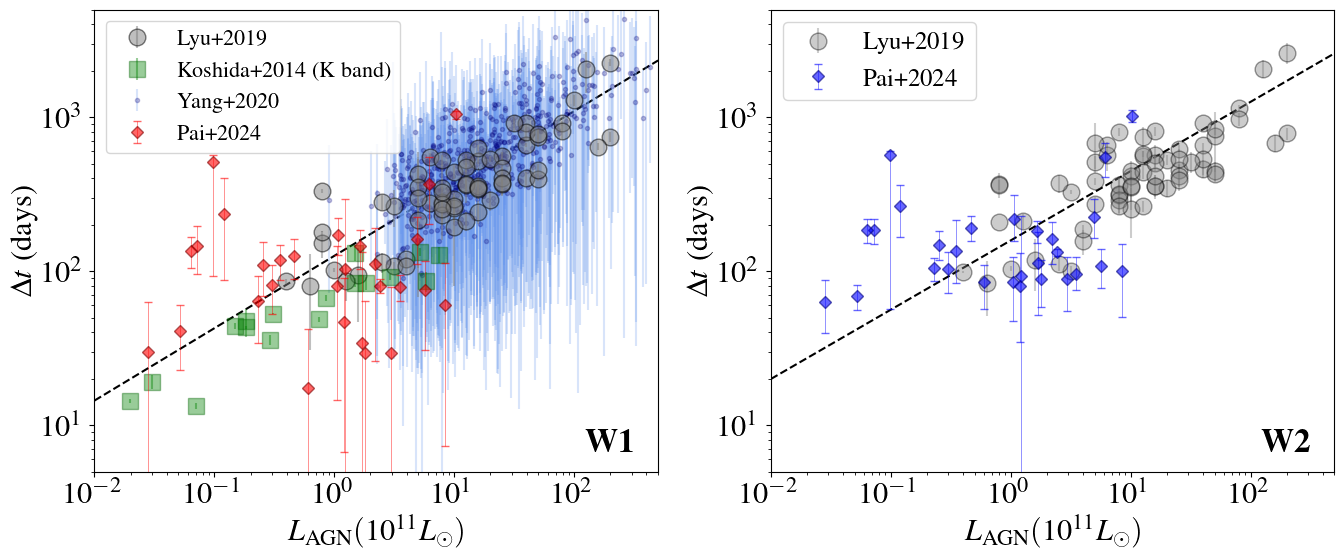

In [105]:
#logL_AGN_ = 4.89+0.91*spectra_5100_luminosity-np.log10(1e11)
x = np.linspace(1e-2, 5e2)
fig, ax = plt.subplots(figsize=(16,6), ncols=2)

ax[0].errorbar(10**LyuW1['L'], LyuW1['w1'], yerr=LyuW1['w1_err'], ls='none', marker='o', ms=12, c='grey', mec='k', alpha=0.5, label='Lyu+2019')
ax[0].errorbar(10**KoshidaW1['L'], KoshidaW1['w1_kosh'], yerr=KoshidaW1['w1_kosh_err'], ls='none', marker='s', ms=12, c='green', mec='darkgreen', alpha=0.4, label='Koshida+2014 (K band)')
ax[0].errorbar(10**YangW1['logL'], YangW1['lag'], yerr=(YangW1['errmin_lag'], YangW1['errmax_lag']), ls='none', marker='.', ms=6, c='cornflowerblue', mfc='navy', mec='navy', alpha=0.25, zorder=-1, label='Yang+2020')
ax[0].errorbar(10**logL_AGN[ind], tab['lag_w1'][ind], yerr=(w1_errmin[ind], w1_errmax[ind]), elinewidth=0.5, ls='none', capsize=3, markeredgecolor='maroon', c='red', alpha=0.6, marker='D',ms=6, zorder=10, label='Pai+2024')

ax[0].plot(x, 10**2.1*x**0.47, c='k', ls='dashed', zorder=-2)

# ax[0].plot(x, 10**2.7*x**0.47, c='grey', ls='dashed', zorder=-2)
# ax[0].plot(x, 10**1.6*x**0.47, c='grey', ls='dashed', zorder=-2)
#ax[0].plot(x, 10**fit_w1[1]*x**fit_w1[0], c='k', ls='dashed', zorder=-2)
ax[0].text(0.87, 0.03, r'\textbf{W1}', fontsize=24, ha='left', va='bottom', transform=ax[0].transAxes)

ax[0].legend(fontsize=16)

ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[0].set_ylim(5, 5e3)
ax[0].set_xlim(1e-2, 5e2)

ax[0].set_ylabel(r'$\Delta t$ (days)')
ax[0].set_xlabel(r'$L_{\mathrm{AGN}} (10^{11}L_{\odot})$')

ax[1].sharex(ax[0])
ax[1].sharey(ax[0])

ax[1].errorbar(10**LyuW2['L'], LyuW2['w2'], yerr=LyuW2['w2_err'], ls='none', marker='o', ms=12, c='grey', mec='k', alpha=0.4, label='Lyu+2019')
ax[1].errorbar(10**(logL_AGN[ind]), (tab['lag_w2'][ind]),yerr=((w2_errmin[ind]),(w2_errmax[ind])), elinewidth=0.5, ls='none', capsize=3, markeredgecolor='navy', c='blue', alpha=0.6, marker='D', ms=6, zorder=10, label='Pai+2024')

ax[1].plot(x, 10**2.2*x**0.45, c='k', ls='dashed', zorder=-2)
ax[1].text(0.87, 0.03, r'\textbf{W2}', fontsize=24, ha='left', va='bottom', transform=ax[1].transAxes)

ax[1].legend(fontsize=18)

ax[1].set_yscale('log')
ax[1].set_xscale('log')

ax[1].set_ylabel(r'$\Delta t$ (days)')
ax[1].set_xlabel(r'$L_{\mathrm{AGN}} (10^{11}L_{\odot})$')

# ax[1].set_ylim(1e1, 5e3)
# ax[1].set_xlim(1e-2, 5e2)

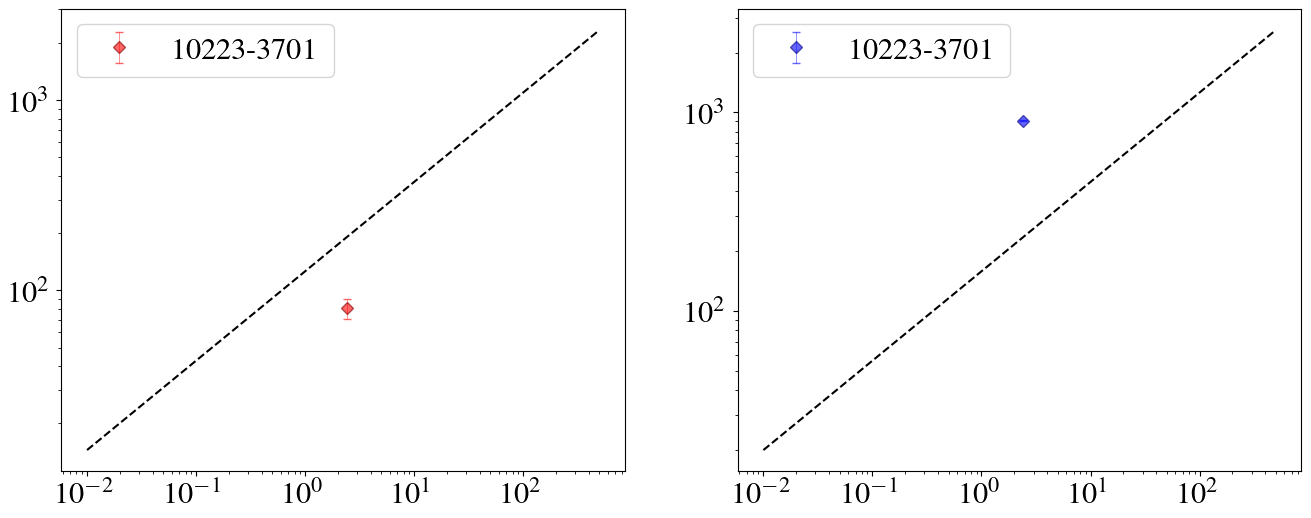

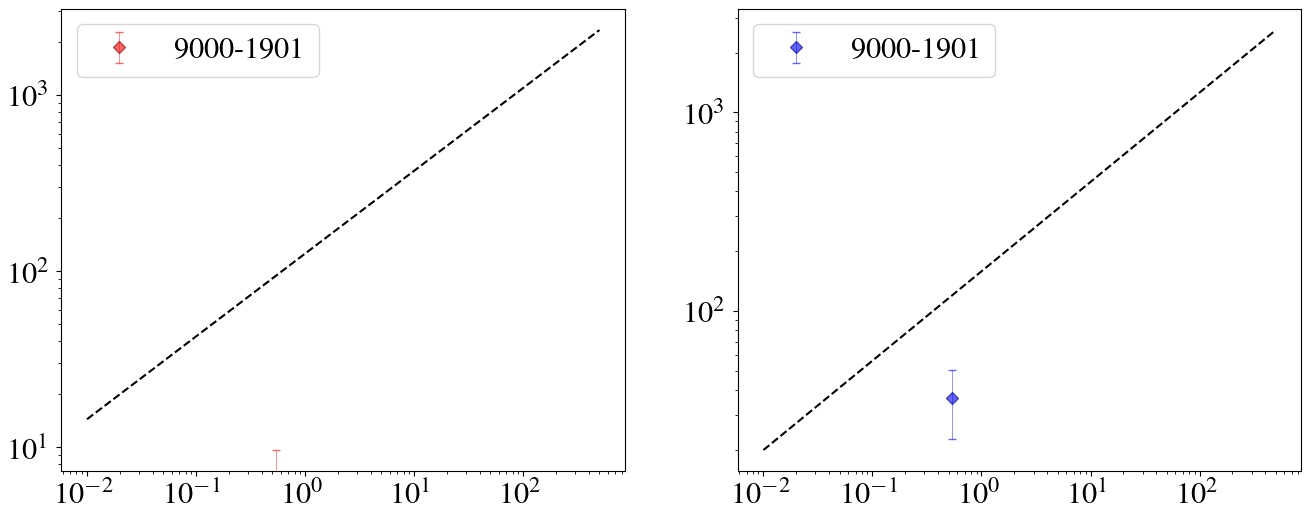

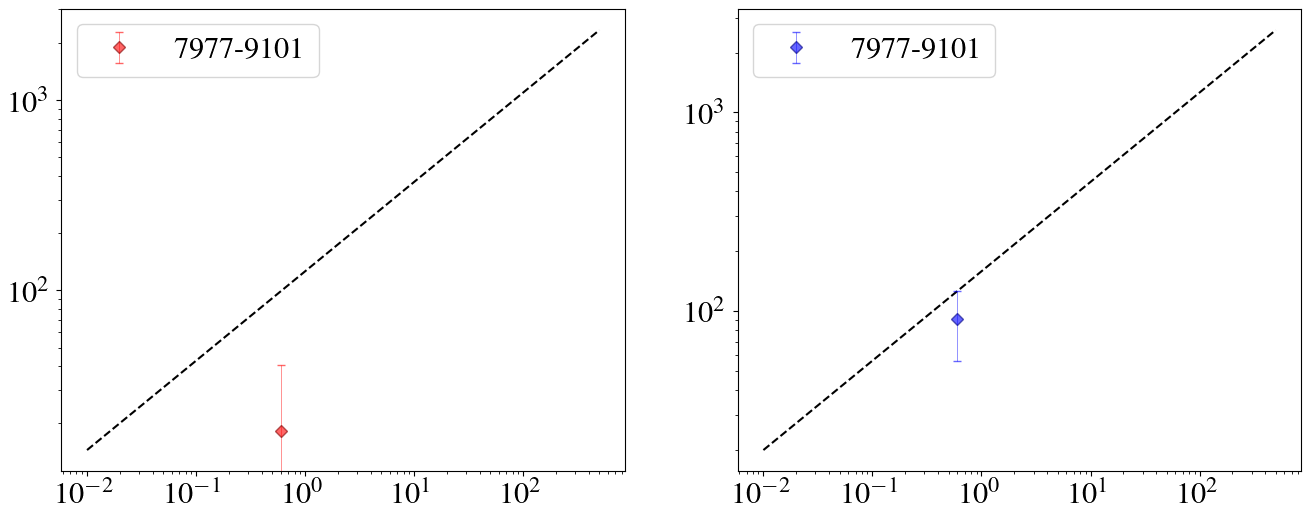

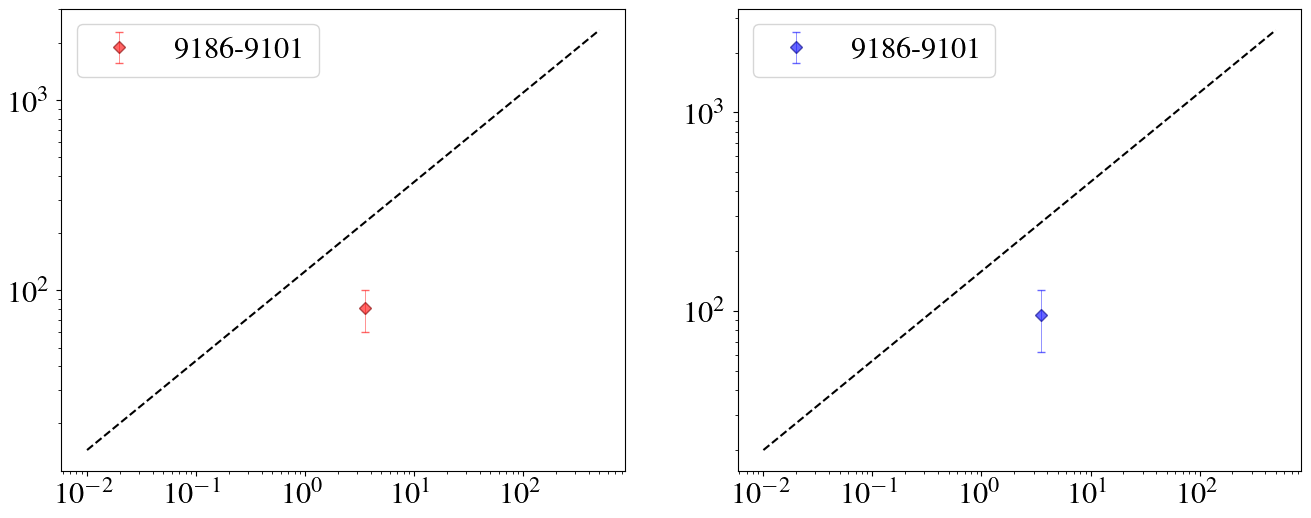

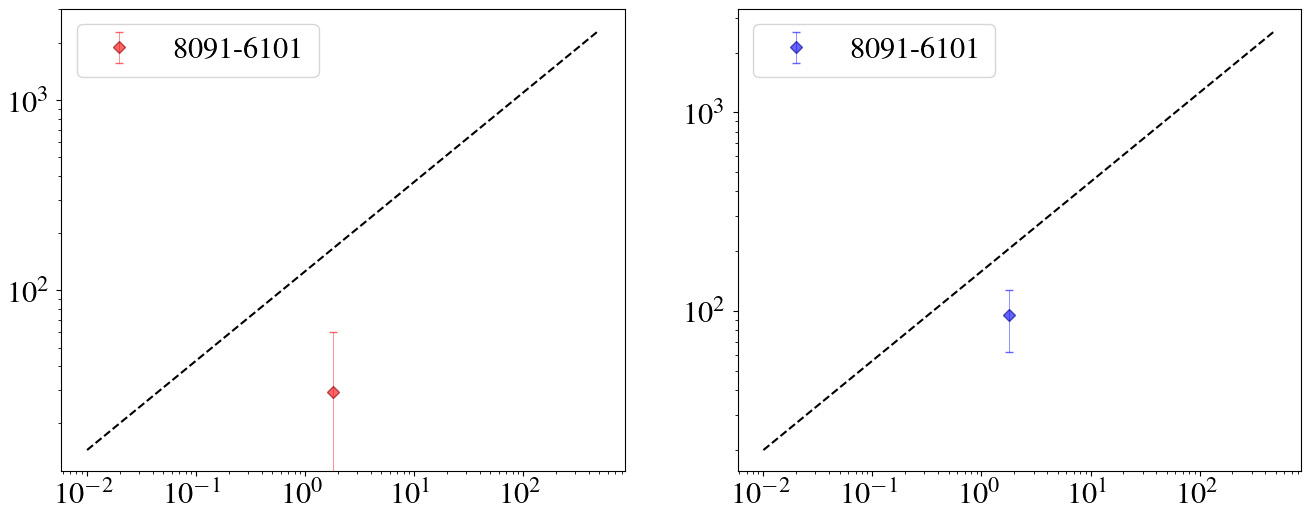

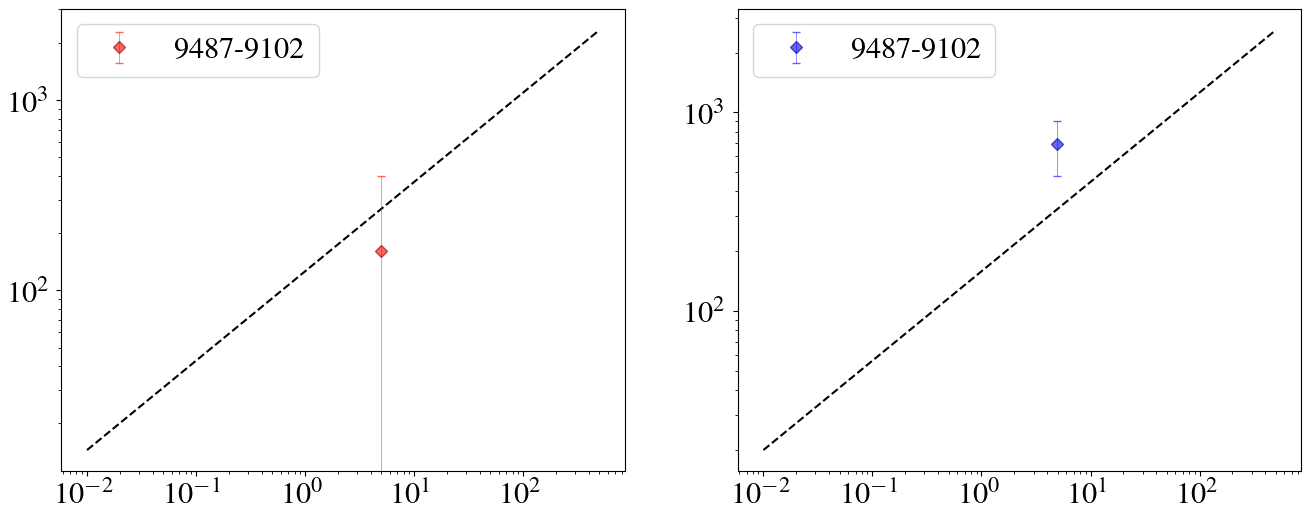

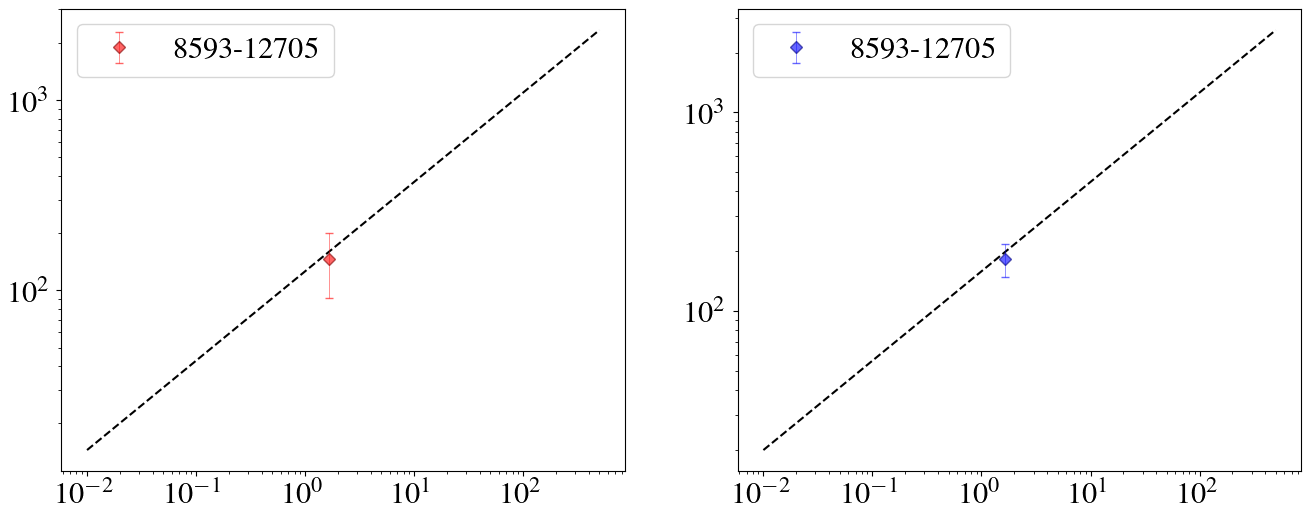

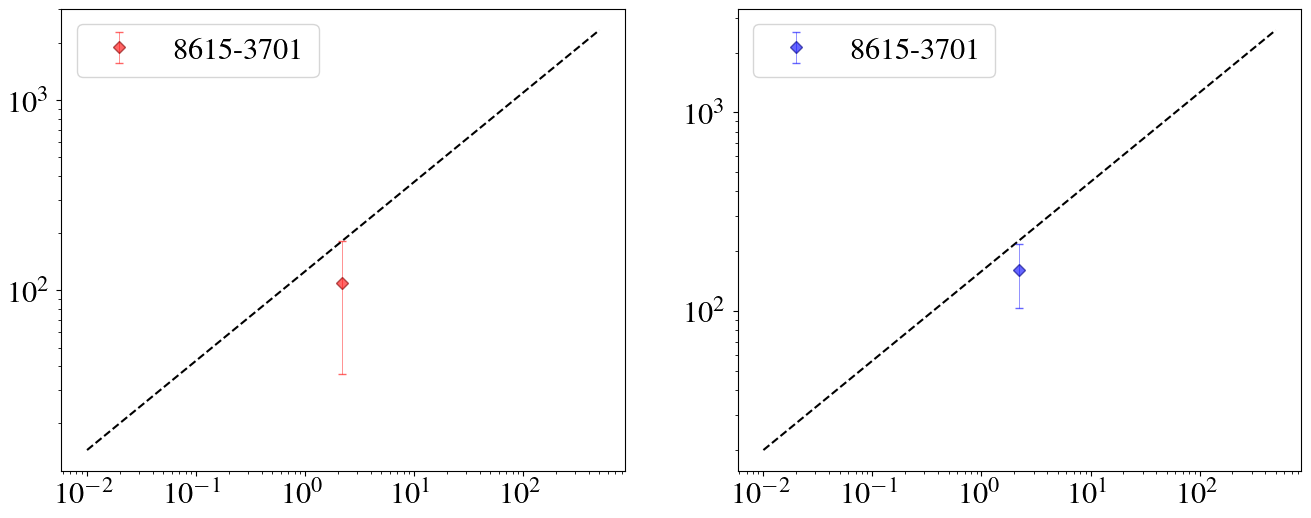

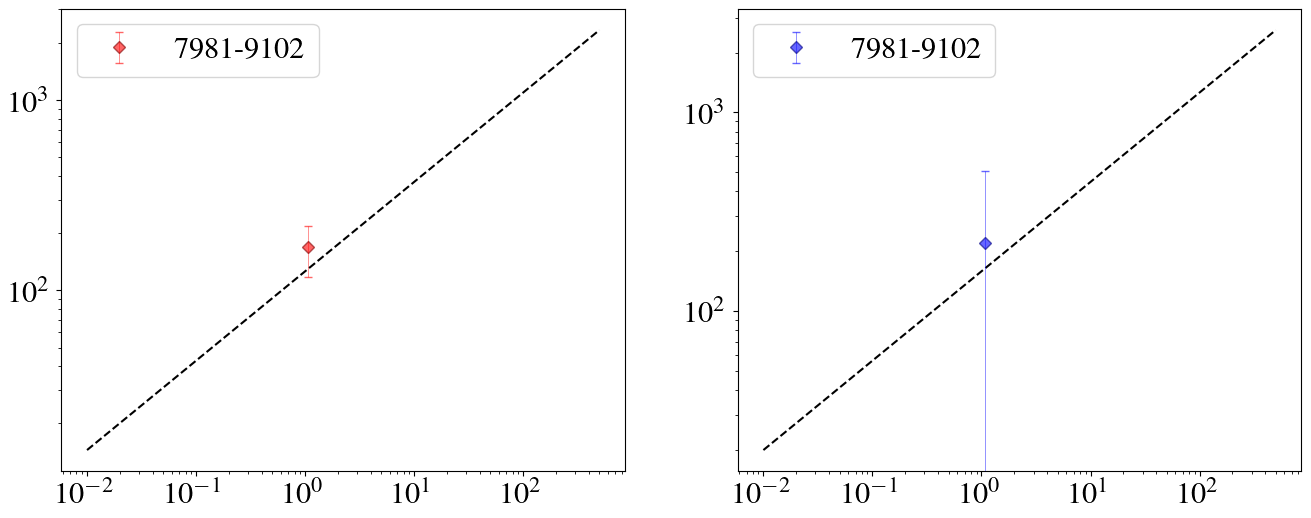

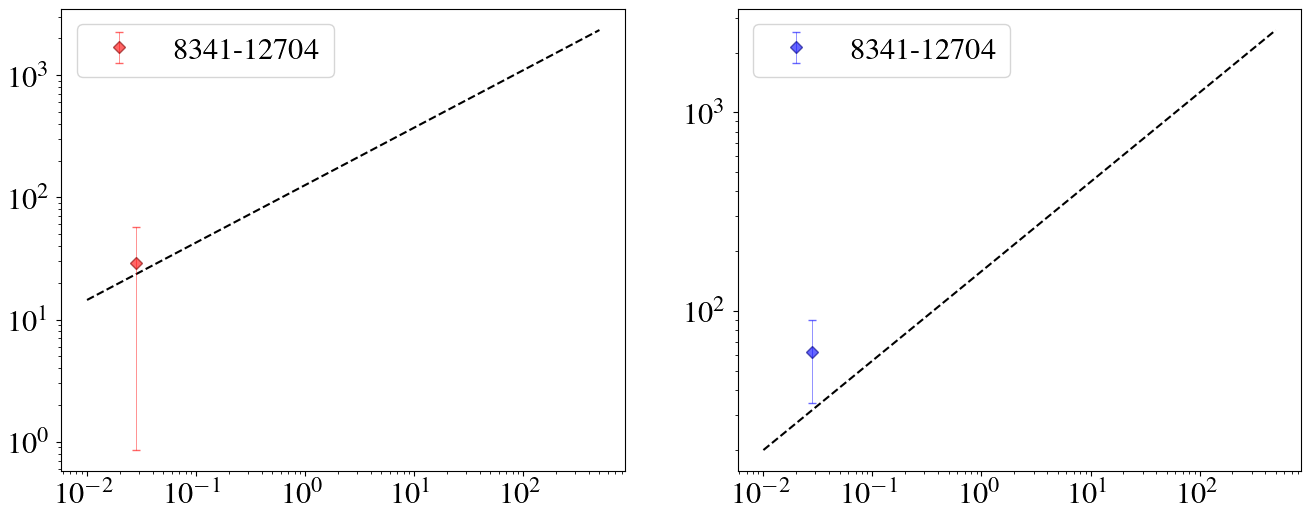

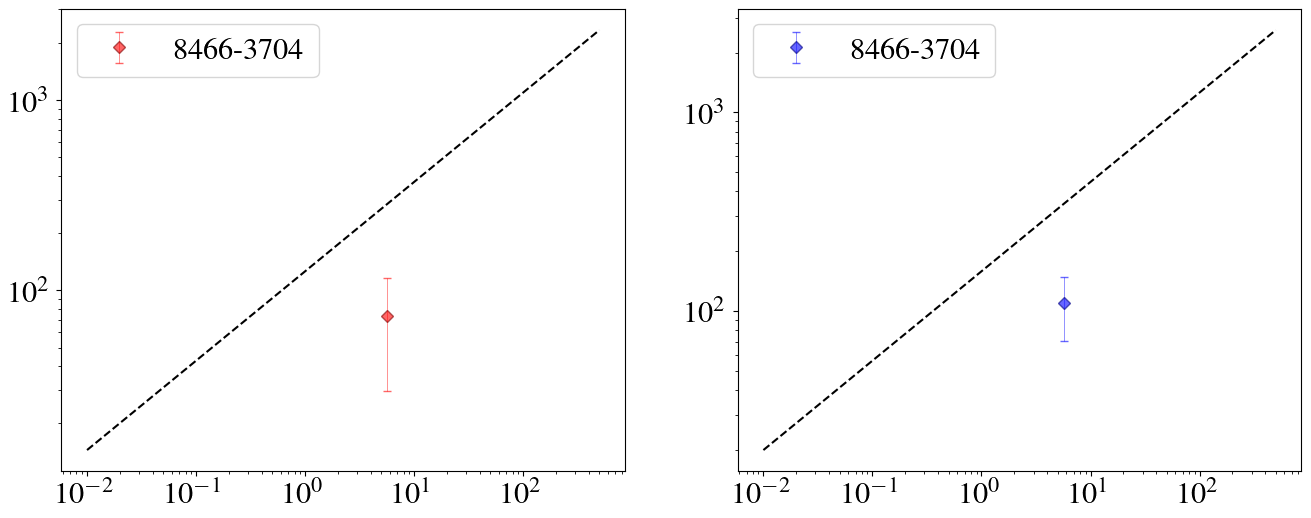

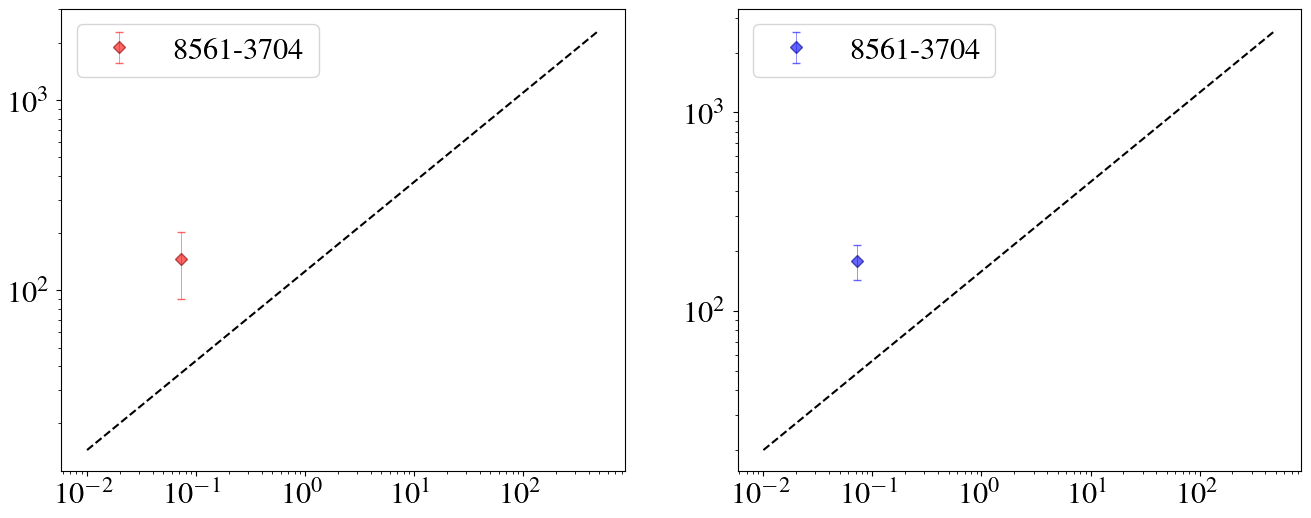

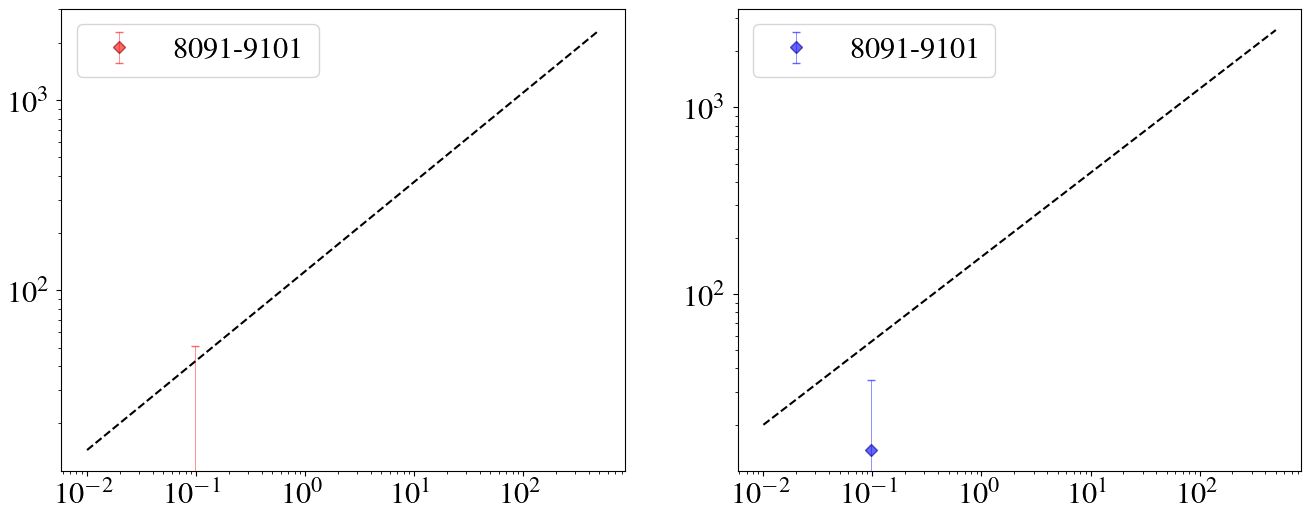

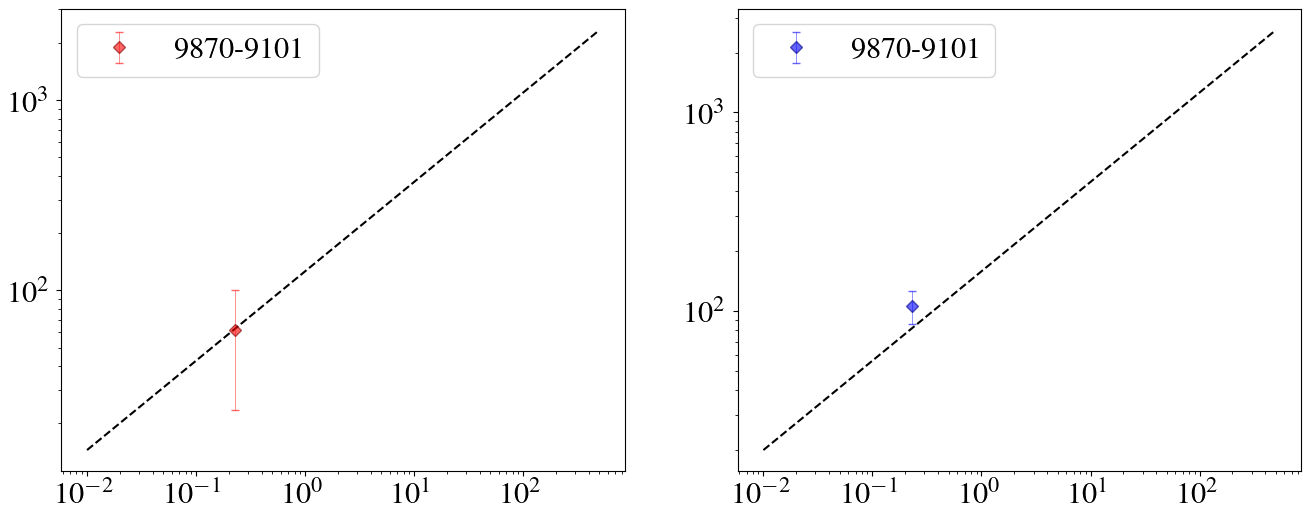

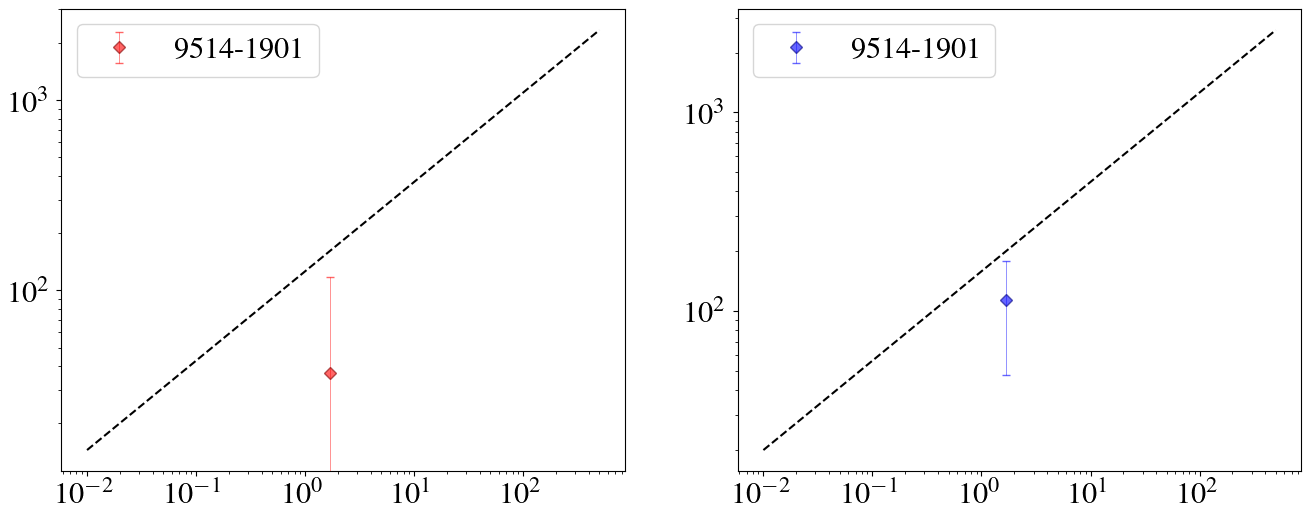

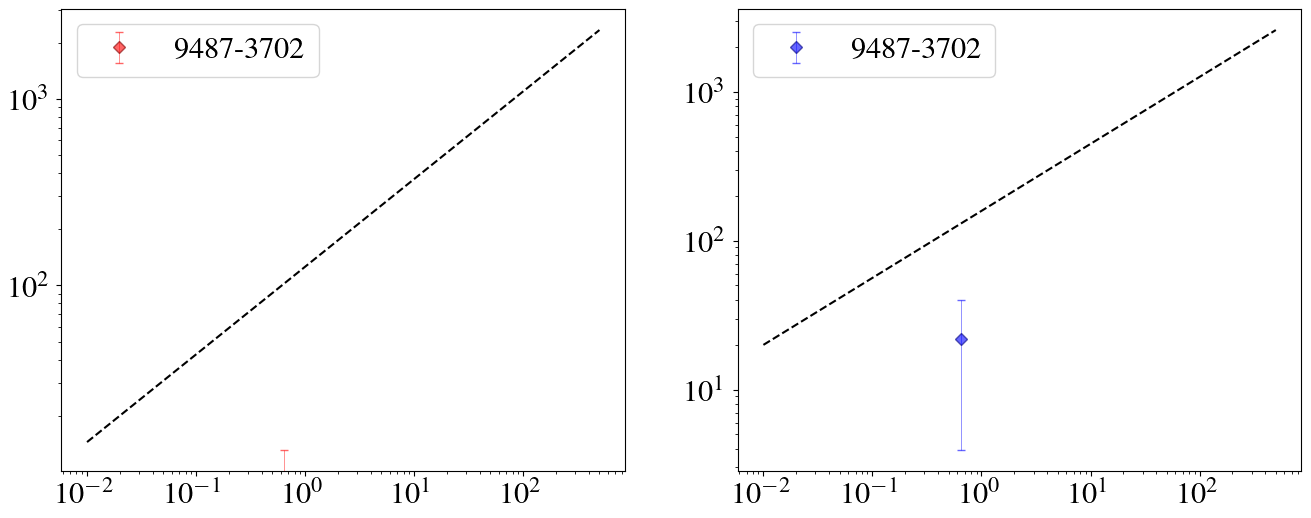

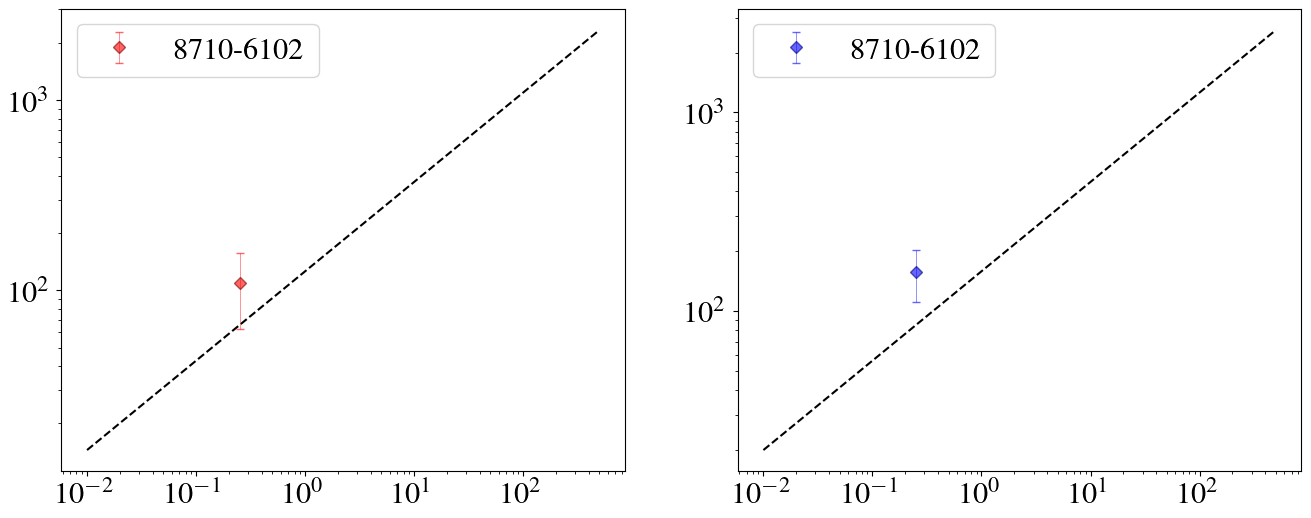

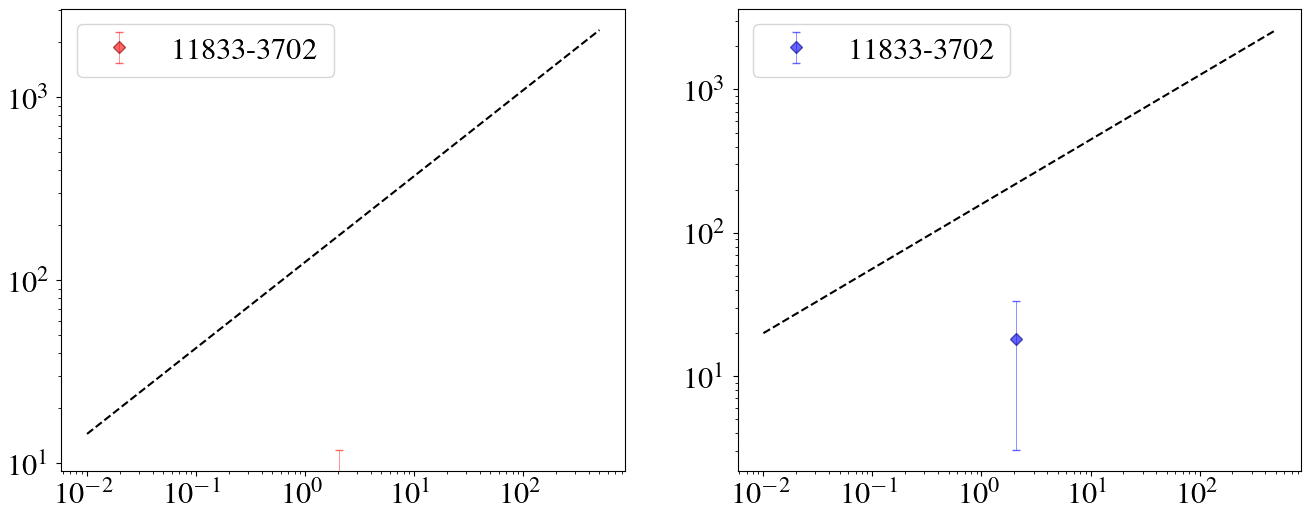

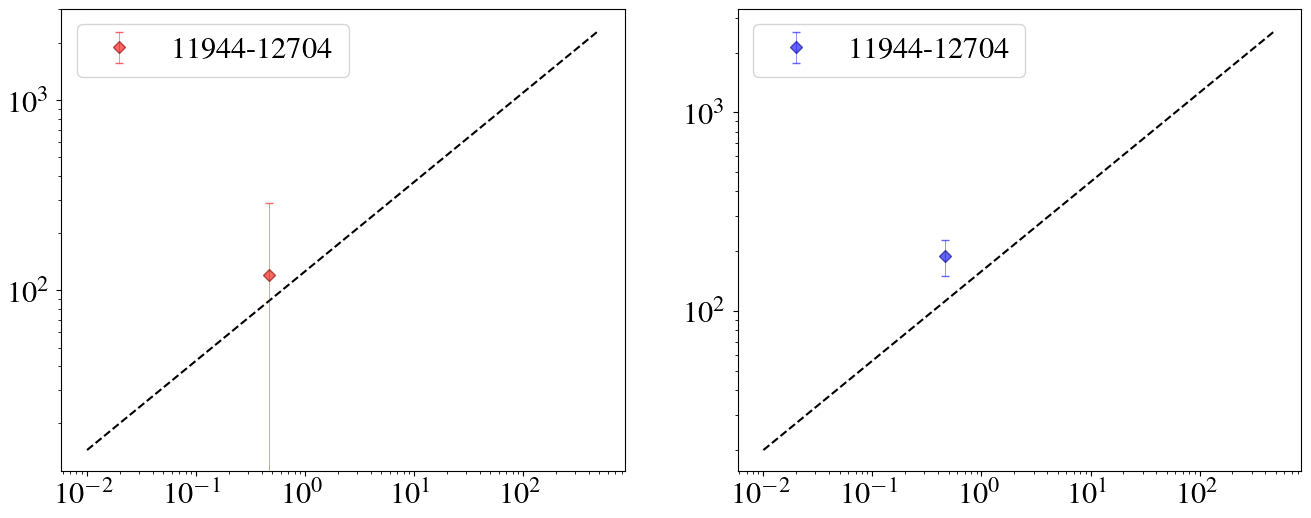

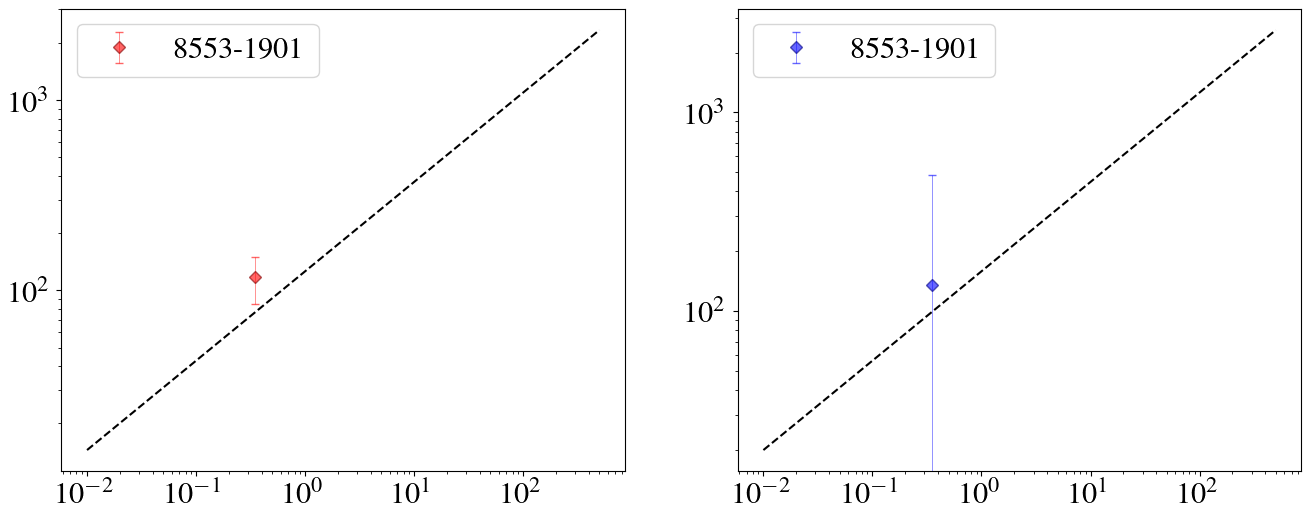

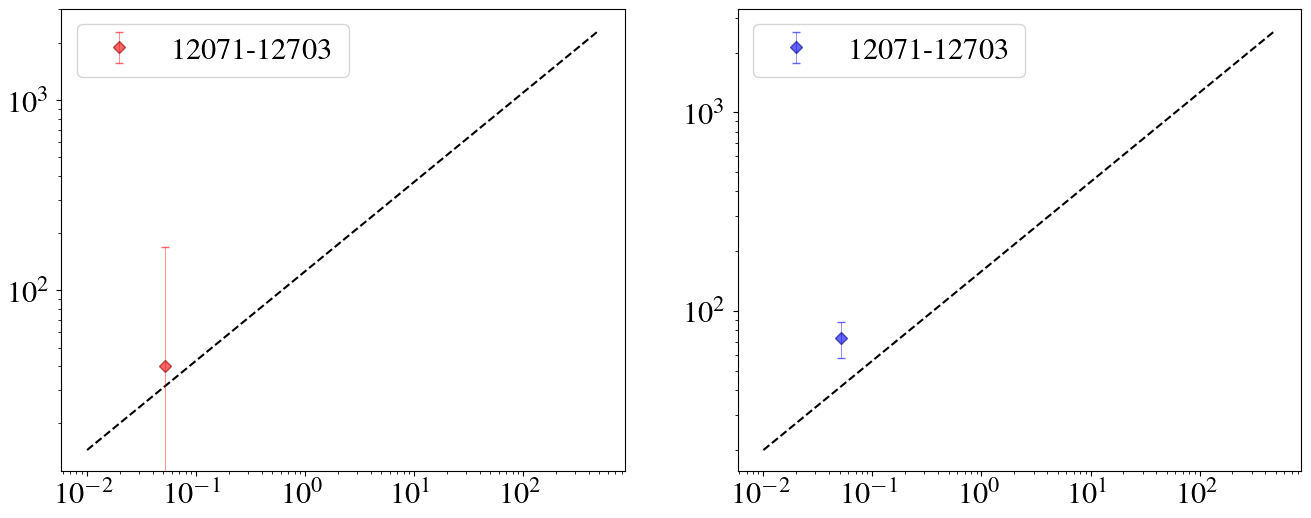

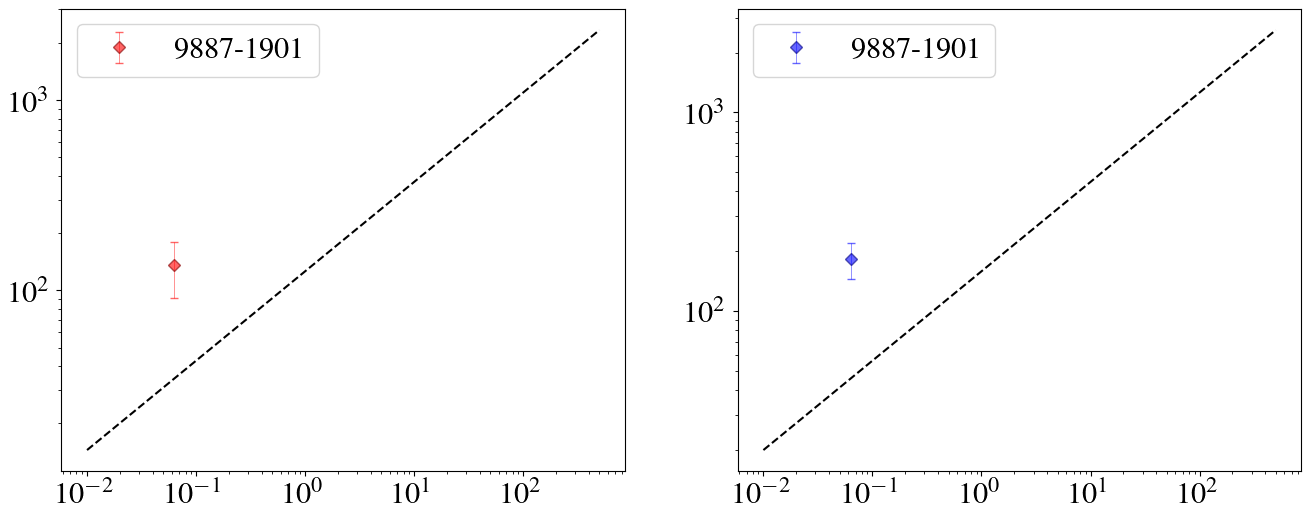

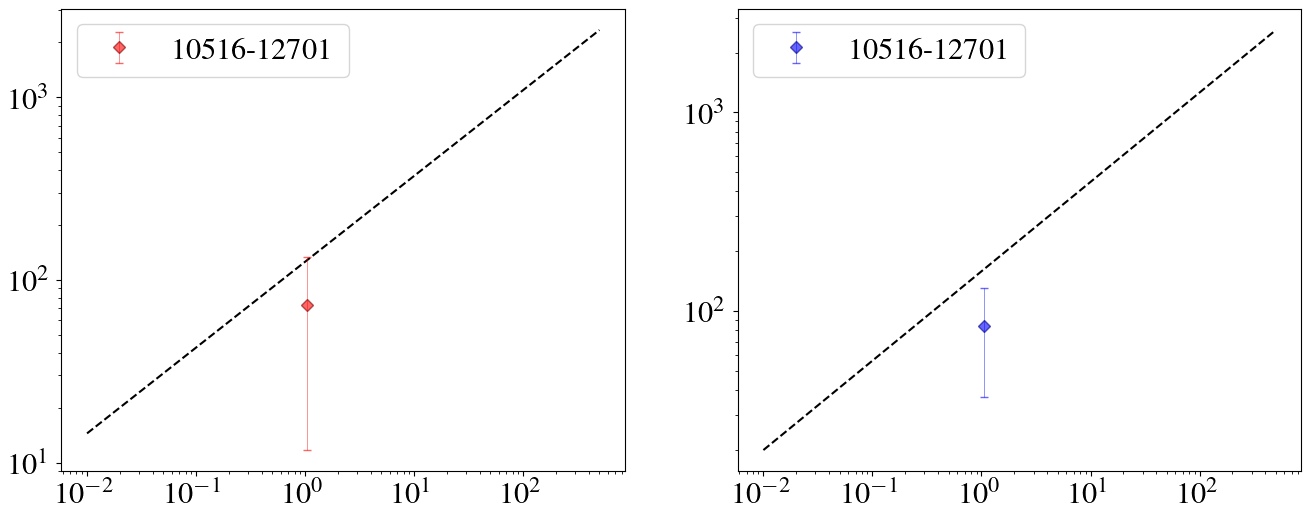

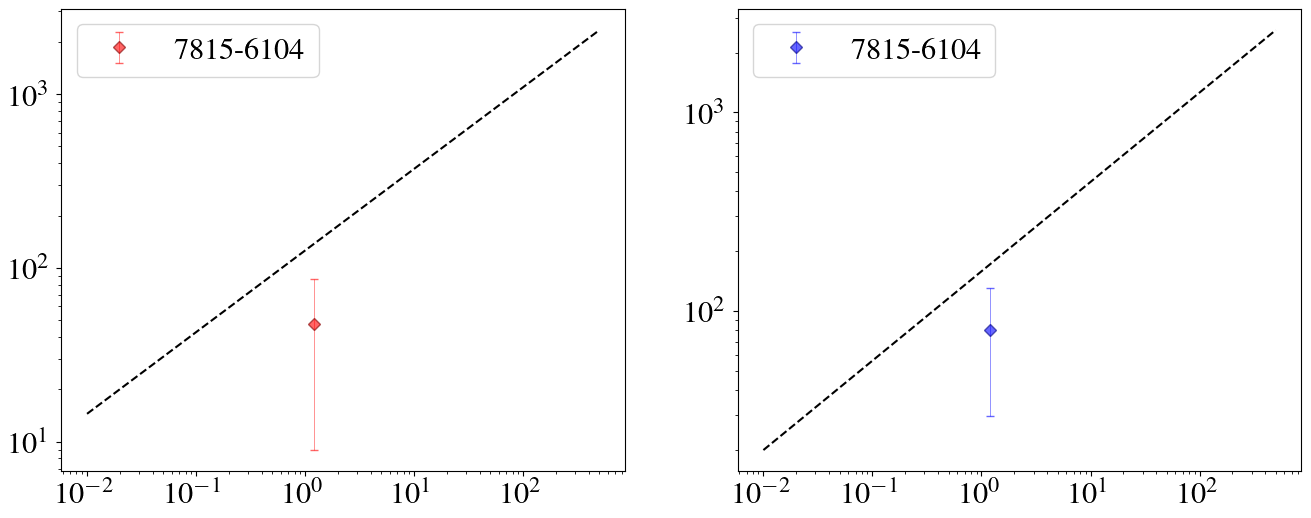

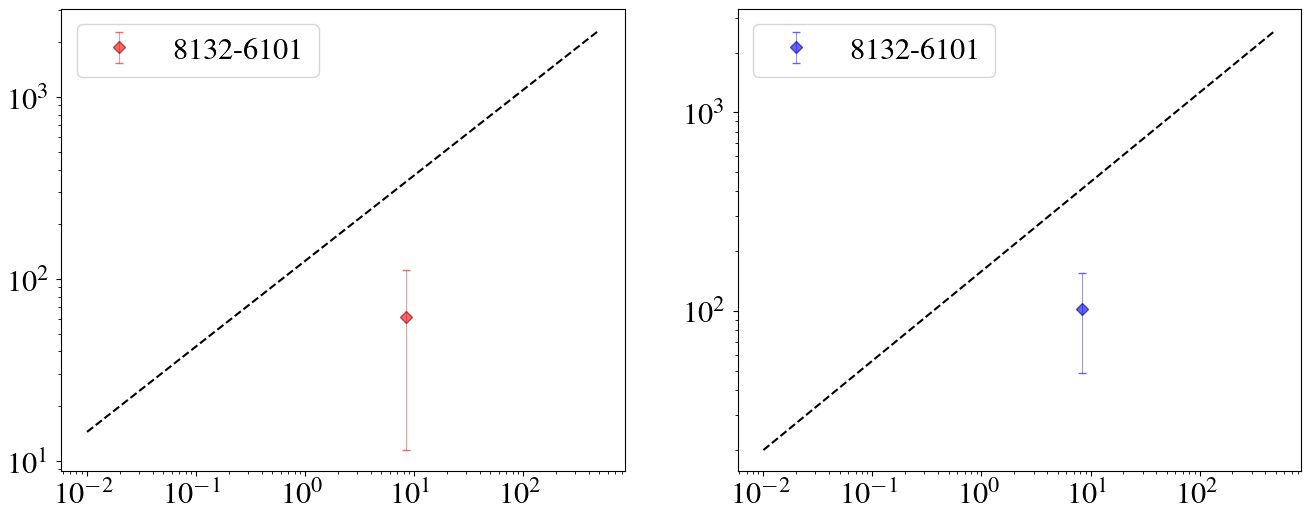

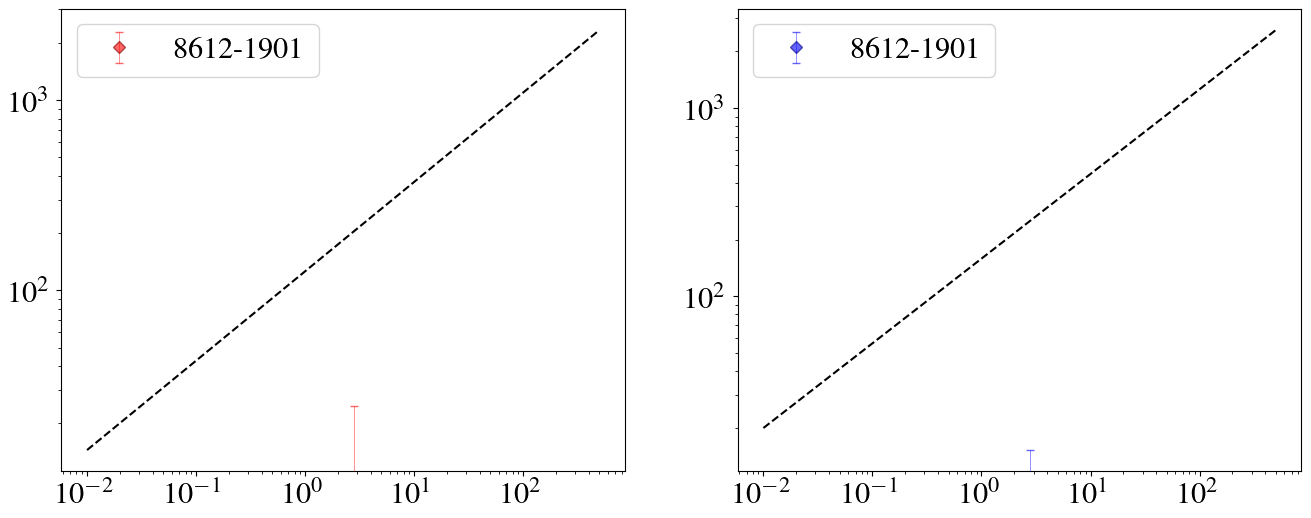

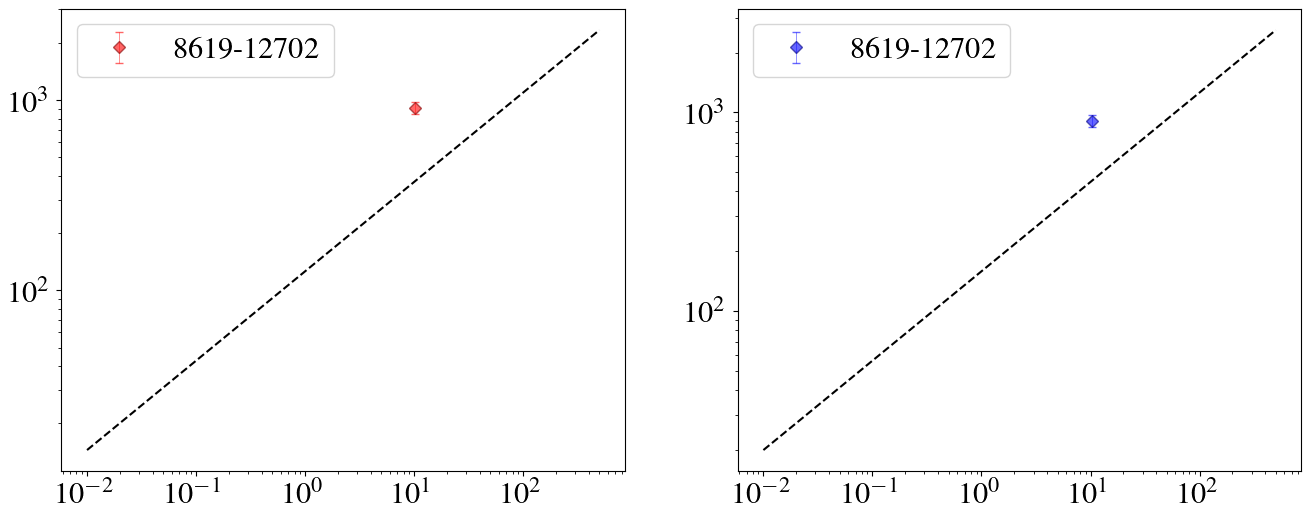

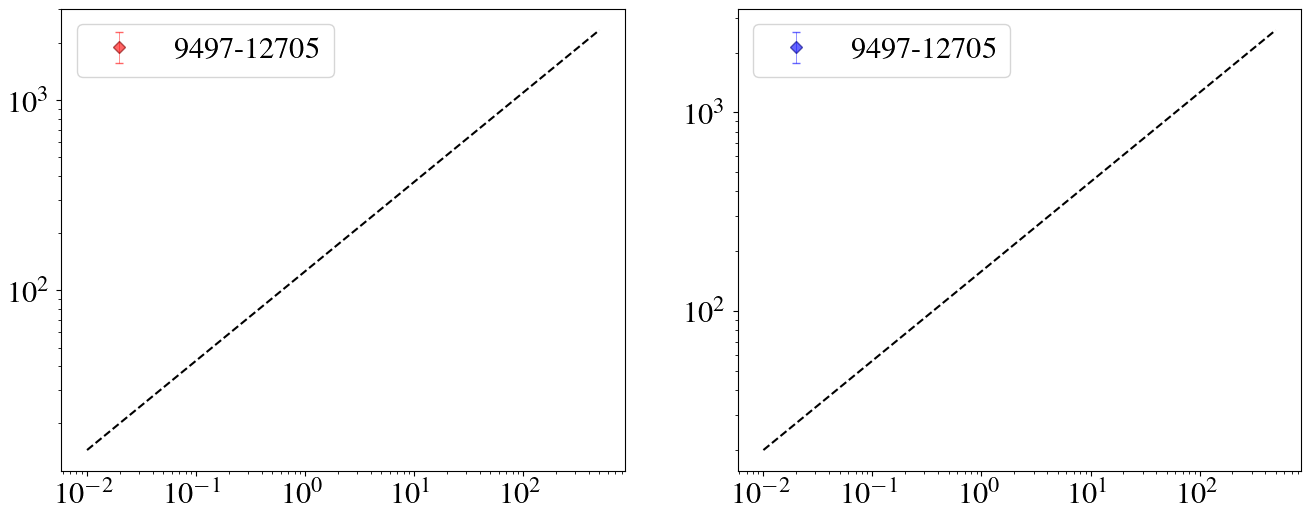

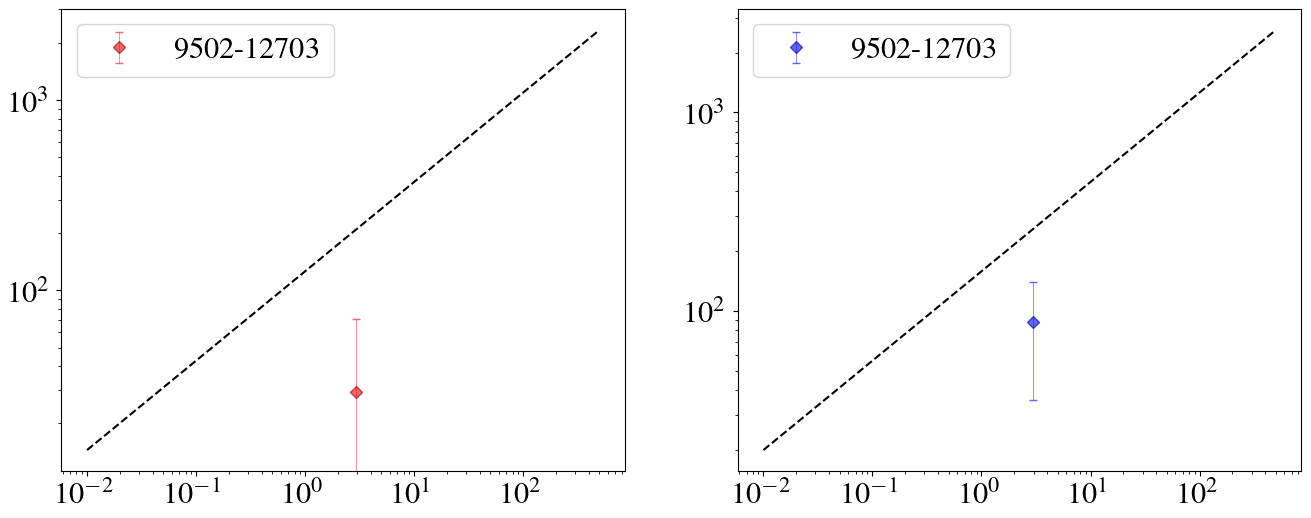

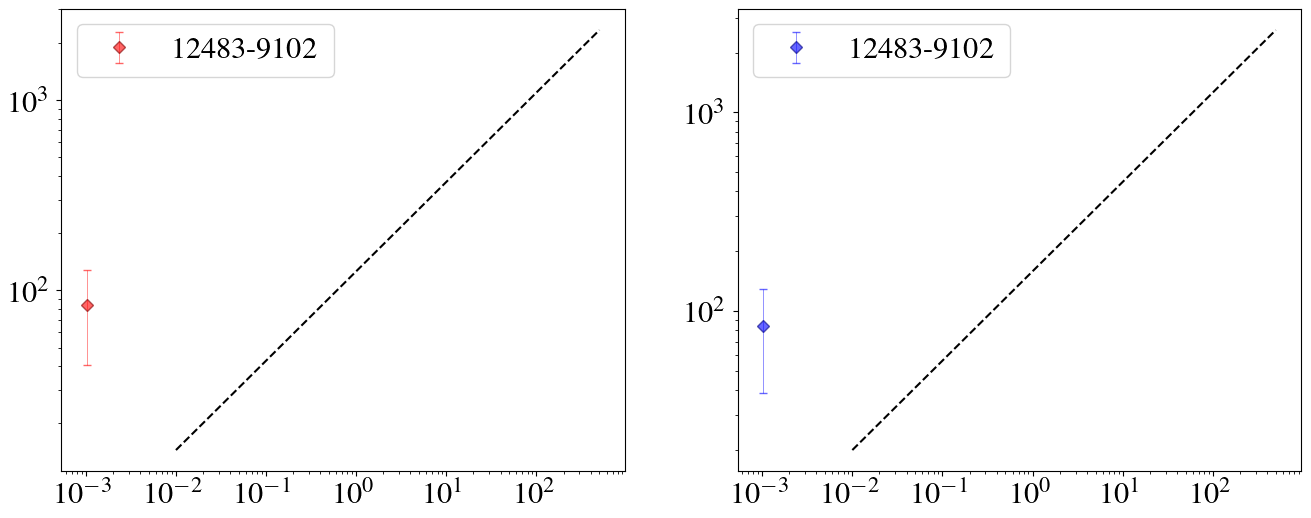

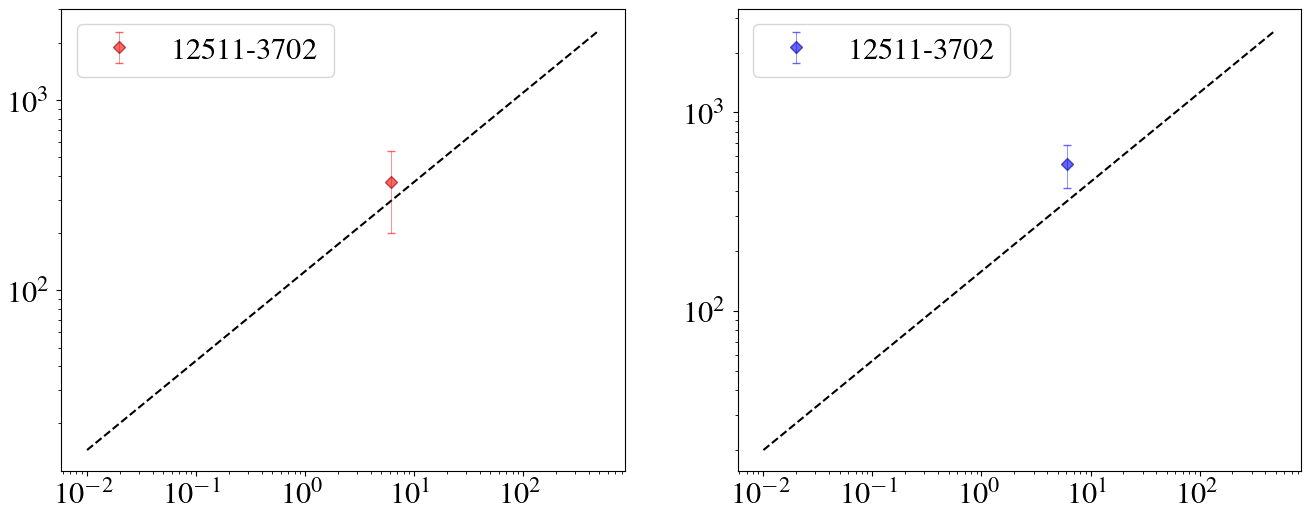

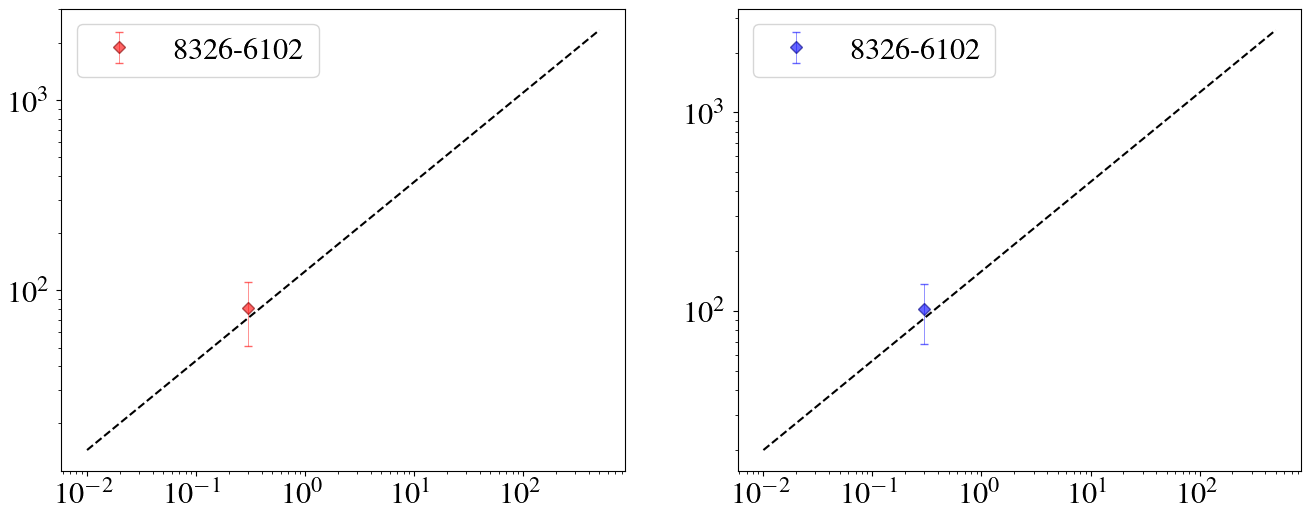

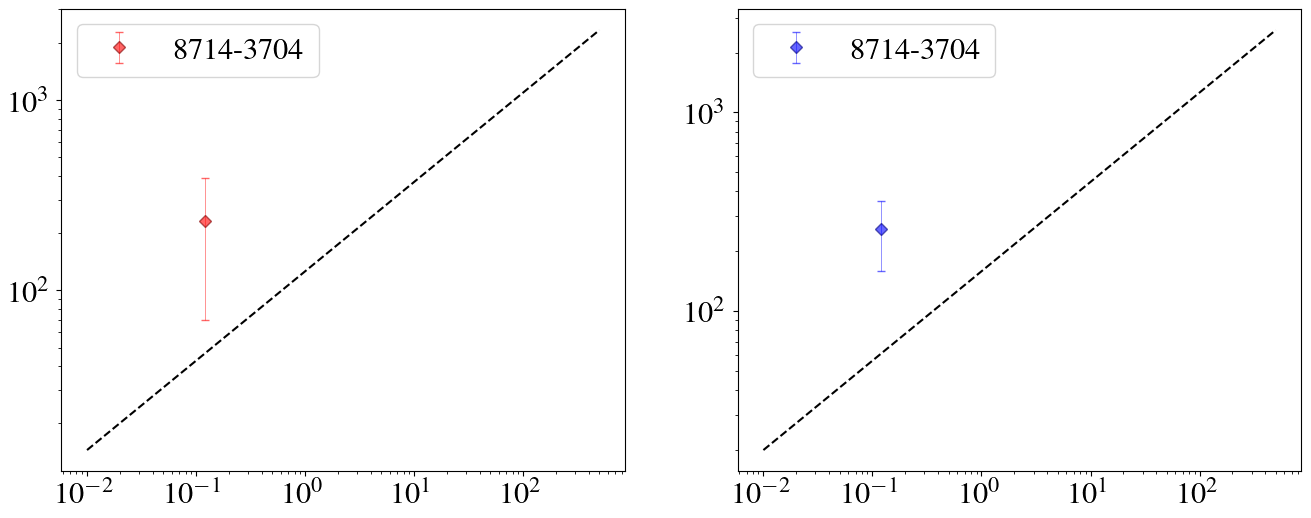

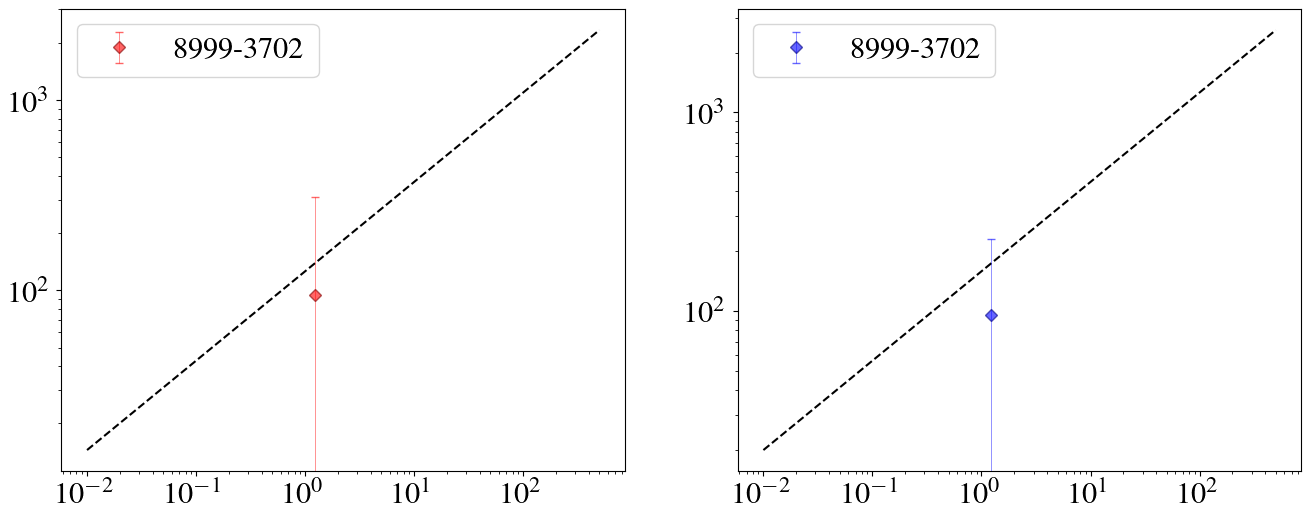

In [ ]:
Lyu_5100_luminosity, 4.89+0.91*spectra_5100_luminosity-np.log10(4e33*1e11), logL_AGN

(array([10.45982267,  9.7397357 ,  9.79199554, 10.63592159, 10.31608009,
        10.798949  , 10.27548816, 10.41144282, 10.06904211,  8.33374216,
        10.8669164 ,  8.782025  ,  8.9270172 ,  9.33447065, 10.28793732,
         9.82630278,  9.38144215, 10.38061609,  9.6710109 ,  9.5365213 ,
         8.62615044,  8.71984887, 10.05851269, 10.1258728 , 11.05463284,
        10.52847066, 11.1494071 ,        -inf, 10.55467876,  6.75550783,
        10.90154113,  9.46293791,  9.02752505, 10.13336299]),
 array([-32.15471165, -32.71676764, -32.70806808, -32.20395667,
        -32.54042923, -32.14459082, -32.26505046, -32.17429606,
        -31.85939249, -32.84060933, -31.64968452, -32.6398763 ,
        -32.61065994, -32.58560903, -32.20940606, -32.39363308,
        -32.63346014, -32.34408186, -32.18273112, -31.99114192,
        -32.53845576, -31.71956833, -32.68708606, -32.28883286,
        -31.85967001, -31.61199928, -31.26709063, -31.61281944,
        -32.5042076 , -35.57194862, -32.01083933, -3

In [ ]:
tab

plateifu,lag_w1,amp_w1,const_w1,lag_w2,amp_w2,const_w2,lag_w1_yerr_max,lag_w1_yerr_min,lag_w2_yerr_max,lag_w2_yerr_min,w1_lag_flag,w2_lag_flag
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32
10223-3701,80.353284,5.612946823934482,13.490747035946677,909.4530780000001,5.955892739010653,13.676762205716985,10.7122467051451,8.867106729534942,8.588706522319658,6.908519957891435,1,1
9000-1901,0.0,1.9013507868307096,13.965150492470839,36.52422000000001,2.0212468421070446,13.888797670509728,6.369878884028503,12.948088293450544,13.56991723852493,13.898100718986846,0,1
7977-9101,18.262110000000003,1.195287473731843,14.231069050238537,91.31055,1.5583148777555473,14.516895875669368,21.08228794032292,23.698706568868193,43.46747643179475,27.278037134243405,0,1
9186-9101,80.353284,0.7862478518493665,13.410885645894268,94.96297200000001,0.703292961621327,13.38021091664989,22.58937916697852,16.781700553565774,38.31514968628092,27.63525915136858,1,1
8091-6101,29.219376000000004,0.9668701176090825,14.02215346910758,94.96297200000001,1.2739663318875216,14.096503303961967,29.071668500359856,33.64053030087559,35.4857278861221,30.553152493742818,0,1
9487-9102,160.706568,1.1503535323197944,13.771833353715843,690.3077580000001,1.6832945904929146,13.782941170043033,76.40474681982779,404.10030858150725,341.8718467663025,83.15041551075583,1,0
8593-12705,146.09688000000003,0.955828091241777,14.006617753015746,182.6211,1.2839068543172152,14.227334778253505,64.91589755255733,45.449702525821785,38.542135140727055,30.813159603634556,1,1
8615-3701,109.57266,1.1441810171720186,15.141542155467915,160.706568,1.955234974439713,15.33119440293353,70.18084077482966,76.16245901832521,61.493715932937164,53.49779553554849,1,1
7981-9102,168.011412,0.6705752238729874,14.837678702546425,219.14532,0.5348394828690015,14.766321327154278,48.66071750039862,52.96622854071563,87.39369064458025,485.79725472395063,1,0
